# <span style="color:turquoise">**Detección de células redondas utilizando Yolo**</span>

## **Hardware**

**PC** Lenovo Idealpad Gaming3

**Procesador** AMD Ryzen 5 5600H with Radeon Graphics 3.3 GHz

	Velocidad de base:	3,30 GHz
	Sockets:	1
	Núcleos:	6
	Procesadores lógicos:	12
	Virtualización:	Habilitado
	Caché L1:	384 kB
	Caché L2:	3,0 MB
	Caché L3:	16,0 MB

**Gráficos dedicados** NVIDIA GeForce RTX 3050 Laptop 

	Versión del controlador:	31.0.15.5176
	Fecha del controlador:	01/03/2024
	Versión de DirectX:	12 (FL 12.1)
	Memoria de GPU dedicada	4,0 GB
	Memoria de GPU compartida	7,7 GB
	Memoria de GPU	11,7 GB
	
**RAM** 16 GB SODIMM DDR4 

	Velocidad:	3200 MHz
	Ranuras usadas:	2 de 2
	Factor de forma:	SODIMM

**Memoria estado sólido** SSD 512 GB 2210 NVMe PCIe Gen3 x4  Micron MTFDHBA512QFD

**Google Colab** 
	12.7 GB RAM, 15 GB RAM GPU Tesla T4, SSD 78.2 GB

In [1]:
!nvidia-smi

Mon Jul 21 00:41:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0              6W /   60W |     493MiB /   4096MiB |     30%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Introducción**

En este TFM se pretende realizar un estudio del arte y entrenamiento de diferentes modelos (YOLO, Fast-RCNN, propio) para la detección de células y artefactos en imágenes médicas. Para esto, se aplican técnicas de visión por computador y aprendizaje profundo. Además, se realizará un exahustiva revisión de la bibliografía existente, mejora del dataset y análisis estadistico fundamentado en las diferentes métricas.

## **Dependencias**

In [2]:
# %pip install -U ipywidgets jupyter
# %pip install ultralytics
# !pip install optuna

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import cv2
import json
import optuna
import shutil

import torch
from ultralytics import YOLO

from lib.YOLO_lib import config, optuna_utils, plot_utils, kfold_utils

In [2]:
print(f"Versión de PyTorch + CUDA: {torch.__version__}")
print(f"Diponible CUDA: {torch.cuda.is_available()}. \nDispositivo CUDA: {torch.cuda.get_device_name(0)}")

Versión de PyTorch + CUDA: 2.6.0+cu126
Diponible CUDA: True. 
Dispositivo CUDA: NVIDIA GeForce RTX 3050 Laptop GPU


## **Entrenamineto de los modelos YOLOv11 y YOLOv12**

### **Configuración**

In [4]:
selected_model = "yolov11l" 
model_dir = "yolo_output/yolo_models"
model_path = os.path.join(model_dir, f"{selected_model}.pt")

if selected_model not in config.models:
    print(f"Modelo '{selected_model}' no encontrado en config.models. Descargando modelo preentrenado...")

    model = YOLO(f"{selected_model}.pt")

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    if not os.path.exists(model_path):
        shutil.move(f"{selected_model}.pt", model_path)
else:
    model = YOLO(config.models[selected_model])

Recuerda que si hemos descargado un nuevo modelo, debemos añadirlo al archivod e configuración.

In [5]:
storage_name = f"sqlite:///optuna/optuna_studies/{selected_model}.db"
best_params_path = f"optuna/optuna_studies/{selected_model}_best_params.json"
image_optuna_path = f'optuna/optuna_plots/optimization_{selected_model}.png'
model_output = f"final_model_{selected_model}"
model_output_kfold = model_output + "_kfold"

### **Optuna**

In [7]:
study = optuna.create_study(
    direction="maximize",  # Maximizar mAP@0.5:0.95
    study_name=selected_model,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed = config.SEED)  
)

study.optimize(lambda trial: optuna_utils.optuna_objective(trial, model, selected_model), n_trials=config.N_TRIALS, timeout=None)

print("Número de trials completados:", len(study.trials))

with open(best_params_path, 'w') as f:
    json.dump(study.best_trial.params, f, indent=2)

[I 2025-07-21 00:41:40,731] Using an existing study with name 'yolov11l' instead of creating a new one.


Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.000590578038473882, lrf=0.00856765558830815, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo11l.pt, momentum=0.9454305666181799, mosaic=0, multi_scale=False, name=optuna_trial_yolov11l_11, nbs=64, nms=False, opset=None, optimize=False, optimizer=A

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 653.0178.9 MB/s, size: 109.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolov11l_11\labels.jpg... 
optimizer: Adam(lr=0.000590578038473882, momentum=0.9454305666181799) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0008556385477088213), 173 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolov11l_11
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.46G      1.989      2.123      1.158         41        704: 100%|██████████| 70/70 [01:15<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]

                   all         70        889      0.573      0.533      0.569      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.55G      1.427      1.309     0.9628         25        704: 100%|██████████| 70/70 [01:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

                   all         70        889       0.73      0.762      0.774      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.53G      1.538      1.447     0.9848         44        704: 100%|██████████| 70/70 [01:31<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]

                   all         70        889      0.657      0.767      0.723      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.57G      1.438      1.166     0.9613         24        704: 100%|██████████| 70/70 [01:04<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

                   all         70        889      0.729      0.719      0.761      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.53G      1.353      1.131     0.9141         79        704: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all         70        889      0.663      0.783      0.692      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.55G      1.246      1.079     0.9193         69        704: 100%|██████████| 70/70 [00:45<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        889      0.764      0.753      0.809      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.54G      1.293      1.084     0.9163         40        704: 100%|██████████| 70/70 [00:37<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        889      0.545      0.829      0.556      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.54G      1.263      1.051     0.9152         40        704: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all         70        889      0.768      0.752      0.794      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.53G      1.187       1.01     0.9037         11        704: 100%|██████████| 70/70 [01:11<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  3.00it/s]

                   all         70        889      0.785      0.799      0.847      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.54G      1.178     0.9629     0.8921         38        704: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        889      0.762      0.766      0.806      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.54G      1.166     0.9622     0.9014         22        704: 100%|██████████| 70/70 [01:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all         70        889      0.758      0.757      0.802      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.58G      1.171     0.9388     0.8862         19        704: 100%|██████████| 70/70 [01:17<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]

                   all         70        889      0.652      0.701       0.71      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.55G      1.155     0.9182     0.8814         33        704: 100%|██████████| 70/70 [01:11<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        889      0.709      0.684      0.728      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.53G      1.156       0.97     0.8883         28        704: 100%|██████████| 70/70 [00:42<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

                   all         70        889      0.699      0.786      0.746      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.57G       1.05     0.9211     0.8735         60        704: 100%|██████████| 70/70 [00:53<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all         70        889      0.784      0.805      0.824      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.54G      1.098     0.8904     0.8847         62        704: 100%|██████████| 70/70 [00:58<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]

                   all         70        889       0.81      0.827      0.858      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.54G       1.07     0.8331     0.8643         86        704: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        889      0.813      0.812      0.858      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.55G      1.058     0.8161     0.8699         34        704: 100%|██████████| 70/70 [00:38<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

                   all         70        889      0.807      0.822      0.863      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.53G      1.048     0.8102     0.8678        107        704: 100%|██████████| 70/70 [01:04<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

                   all         70        889       0.81      0.823      0.868      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.56G          1     0.7873     0.8548         17        704: 100%|██████████| 70/70 [01:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        889      0.783      0.835      0.847      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.55G      1.016     0.7551     0.8679         32        704: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all         70        889      0.798      0.822      0.867      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.53G      1.013     0.7603     0.8643         57        704: 100%|██████████| 70/70 [00:46<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]

                   all         70        889      0.788      0.838      0.862      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.54G      0.988     0.7694     0.8574         34        704: 100%|██████████| 70/70 [00:35<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]

                   all         70        889       0.78      0.838      0.862      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.55G     0.9674     0.7448     0.8482         56        704: 100%|██████████| 70/70 [00:36<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        889      0.796      0.828      0.865      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.55G     0.9606     0.7235     0.8604         37        704: 100%|██████████| 70/70 [00:38<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all         70        889      0.807      0.814      0.867      0.653



25 epochs completed in 0.405 hours.
Optimizer stripped from runs\detect\optuna_trial_yolov11l_11\weights\last.pt, 51.2MB
Optimizer stripped from runs\detect\optuna_trial_yolov11l_11\weights\best.pt, 51.2MB

Validating runs\detect\optuna_trial_yolov11l_11\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]


                   all         70        889        0.8      0.818      0.867      0.653
Speed: 0.6ms preprocess, 34.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\optuna_trial_yolov11l_11


[I 2025-07-21 01:06:39,142] Trial 11 finished with value: 0.653129185875398 and parameters: {'lr0': 0.000590578038473882, 'lrf': 0.00856765558830815, 'momentum': 0.9454305666181799, 'weight_decay': 0.0008556385477088213, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.653129185875398.


Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0006415261662742608, lrf=0.00962555009311638, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo11l.pt, momentum=0.9469715165030841, mosaic=0, multi_scale=False, name=optuna_trial_yolov11l_12, nbs=64, nms=False, opset=None, optimize=False, optimizer=

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 618.9113.3 MB/s, size: 109.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolov11l_12\labels.jpg... 
optimizer: Adam(lr=0.0006415261662742608, momentum=0.9469715165030841) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0008850379152651265), 173 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolov11l_12
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.48G       1.25     0.9163     0.9114         41        704: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]

                   all         70        889       0.78      0.804      0.846      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.55G      1.187     0.8865     0.8993         25        704: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all         70        889      0.771      0.816       0.83      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.54G      1.221      0.968     0.9038         44        704: 100%|██████████| 70/70 [01:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]

                   all         70        889      0.772      0.832      0.821      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.58G      1.148     0.9074     0.8921         24        704: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]

                   all         70        889      0.701      0.802      0.752      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.54G      1.142     0.8756     0.8706         79        704: 100%|██████████| 70/70 [00:45<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

                   all         70        889      0.566      0.812        0.6      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.56G      1.102     0.8744     0.8887         69        704: 100%|██████████| 70/70 [00:47<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all         70        889      0.806      0.792      0.854       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.54G      1.146     0.8595     0.8846         40        704: 100%|██████████| 70/70 [00:43<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]

                   all         70        889      0.773      0.834      0.859      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.54G      1.088      0.828     0.8795         40        704: 100%|██████████| 70/70 [00:38<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

                   all         70        889      0.801      0.813      0.852      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.54G      1.117     0.8016     0.8815         11        704: 100%|██████████| 70/70 [00:36<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]

                   all         70        889      0.816      0.814      0.868      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.54G      1.044     0.7955     0.8674         38        704: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

                   all         70        889      0.805      0.805      0.862      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.54G      1.026     0.7829     0.8687         22        704: 100%|██████████| 70/70 [01:04<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]

                   all         70        889      0.796      0.831      0.858      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.58G      1.046     0.7822     0.8638         19        704: 100%|██████████| 70/70 [00:45<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.27it/s]

                   all         70        889      0.795      0.811      0.851      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.56G     0.9911     0.7511     0.8584         33        704: 100%|██████████| 70/70 [00:56<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]

                   all         70        889      0.821      0.823      0.873      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.54G      1.037     0.7805     0.8713         28        704: 100%|██████████| 70/70 [01:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

                   all         70        889      0.818       0.83      0.879      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.56G     0.9868     0.7389     0.8601         60        704: 100%|██████████| 70/70 [00:37<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

                   all         70        889      0.805      0.823      0.868      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.55G     0.9918     0.7588     0.8611         62        704: 100%|██████████| 70/70 [00:34<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all         70        889      0.824       0.82      0.875       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.55G      1.029      0.753     0.8518         86        704: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]

                   all         70        889      0.814      0.821      0.868      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.56G      1.024     0.7523     0.8581         34        704: 100%|██████████| 70/70 [00:39<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all         70        889      0.823      0.825      0.865      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.54G      1.061     0.7647     0.8642        107        704: 100%|██████████| 70/70 [00:32<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        889      0.815      0.826      0.872      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.56G      1.008     0.7198     0.8495         17        704: 100%|██████████| 70/70 [00:37<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        889      0.815      0.822      0.866      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.56G     0.9119     0.6696     0.8453         32        704: 100%|██████████| 70/70 [00:35<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all         70        889      0.818      0.826      0.878      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.54G     0.9609     0.6874     0.8483         57        704: 100%|██████████| 70/70 [00:37<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]

                   all         70        889      0.788      0.844      0.872      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.54G     0.9246     0.6865     0.8457         34        704: 100%|██████████| 70/70 [00:55<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all         70        889      0.799      0.829      0.862      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.56G     0.9303     0.6811     0.8404         56        704: 100%|██████████| 70/70 [00:46<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]

                   all         70        889      0.805       0.83      0.871      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.55G     0.9149     0.6628     0.8528         37        704: 100%|██████████| 70/70 [00:36<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70        889      0.805      0.824      0.872      0.653



25 epochs completed in 0.336 hours.
Optimizer stripped from runs\detect\optuna_trial_yolov11l_12\weights\last.pt, 51.2MB
Optimizer stripped from runs\detect\optuna_trial_yolov11l_12\weights\best.pt, 51.2MB

Validating runs\detect\optuna_trial_yolov11l_12\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]


                   all         70        889      0.806      0.825      0.872      0.653
Speed: 0.5ms preprocess, 34.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\optuna_trial_yolov11l_12


[I 2025-07-21 01:27:23,768] Trial 12 finished with value: 0.6529164068442392 and parameters: {'lr0': 0.0006415261662742608, 'lrf': 0.00962555009311638, 'momentum': 0.9469715165030841, 'weight_decay': 0.0008850379152651265, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.653129185875398.


Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0006286445359610205, lrf=0.006036116659696321, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo11l.pt, momentum=0.9460386287280202, mosaic=0, multi_scale=False, name=optuna_trial_yolov11l_13, nbs=64, nms=False, opset=None, optimize=False, optimizer

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 665.458.5 MB/s, size: 109.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolov11l_13\labels.jpg... 
optimizer: Adam(lr=0.0006286445359610205, momentum=0.9460386287280202) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0009815765876190572), 173 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolov11l_13
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.49G     0.9583     0.7219     0.8551         41        704: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        889      0.793      0.808      0.861       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.56G      1.024     0.7463     0.8631         25        704: 100%|██████████| 70/70 [00:50<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.09it/s]

                   all         70        889      0.778      0.847      0.868      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.53G      1.043     0.8091     0.8656         44        704: 100%|██████████| 70/70 [00:51<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]

                   all         70        889      0.753      0.816       0.83      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.58G      1.049     0.7608       0.87         24        704: 100%|██████████| 70/70 [01:15<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all         70        889      0.767      0.749      0.775       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.54G      1.102      0.856     0.8613         79        704: 100%|██████████| 70/70 [00:48<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all         70        889      0.593      0.477      0.473      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.56G      1.018     0.8509     0.8705         69        704: 100%|██████████| 70/70 [00:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]

                   all         70        889      0.661        0.8      0.768      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.54G      1.013     0.8439     0.8611         40        704: 100%|██████████| 70/70 [00:52<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

                   all         70        889      0.795      0.785      0.841      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.54G     0.9634     0.7666     0.8571         40        704: 100%|██████████| 70/70 [00:53<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]

                   all         70        889      0.787      0.802      0.856      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.54G       1.04     0.7449      0.872         11        704: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]

                   all         70        889      0.808      0.821      0.873      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.54G      1.026     0.7239     0.8685         38        704: 100%|██████████| 70/70 [00:49<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        889      0.798      0.834      0.873      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.54G      1.012     0.7396     0.8694         22        704: 100%|██████████| 70/70 [00:58<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all         70        889      0.761      0.681      0.737      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.58G      1.035     0.7497     0.8565         19        704: 100%|██████████| 70/70 [00:44<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]

                   all         70        889      0.708      0.726      0.677      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.55G     0.9801     0.7058     0.8508         33        704: 100%|██████████| 70/70 [01:13<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]

                   all         70        889      0.788      0.804      0.853      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.53G     0.9621     0.7009     0.8555         28        704: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all         70        889      0.813      0.816      0.863      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.57G     0.9056     0.6899     0.8444         60        704: 100%|██████████| 70/70 [01:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all         70        889      0.772      0.763      0.775      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.55G     0.9712     0.7091     0.8579         62        704: 100%|██████████| 70/70 [01:04<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]

                   all         70        889      0.818      0.828      0.871      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.55G     0.9672     0.6998     0.8461         86        704: 100%|██████████| 70/70 [00:59<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all         70        889      0.798      0.818      0.858      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.57G     0.9355     0.6894     0.8454         34        704: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        889      0.797      0.829      0.867      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.54G     0.9484     0.7025     0.8482        107        704: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

                   all         70        889        0.8      0.835      0.873      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.56G     0.9172     0.6766      0.836         17        704: 100%|██████████| 70/70 [00:50<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all         70        889      0.787      0.735      0.753      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.56G     0.8898     0.6416     0.8434         32        704: 100%|██████████| 70/70 [01:20<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        889      0.792      0.742      0.772      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.53G     0.9051     0.6492     0.8423         57        704: 100%|██████████| 70/70 [00:32<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        889      0.803      0.682      0.756       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.54G     0.8962     0.6532     0.8437         34        704: 100%|██████████| 70/70 [00:34<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        889      0.758      0.664      0.681      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.55G      0.896     0.6532     0.8343         56        704: 100%|██████████| 70/70 [00:44<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all         70        889        0.8      0.697      0.769      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.56G     0.8744     0.6321     0.8448         37        704: 100%|██████████| 70/70 [00:36<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        889      0.805      0.683       0.75      0.523



25 epochs completed in 0.402 hours.
Optimizer stripped from runs\detect\optuna_trial_yolov11l_13\weights\last.pt, 51.2MB


[I 2025-07-21 01:52:07,220] Trial 13 finished with value: 0.523076607957332 and parameters: {'lr0': 0.0006286445359610205, 'lrf': 0.006036116659696321, 'momentum': 0.9460386287280202, 'weight_decay': 0.0009815765876190572, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.653129185875398.


Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0012123634441485443, lrf=0.006686145527494946, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo11l.pt, momentum=0.9498431644709179, mosaic=0, multi_scale=False, name=optuna_trial_yolov11l_14, nbs=64, nms=False, opset=None, optimize=False, optimizer

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 737.376.2 MB/s, size: 109.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolov11l_14\labels.jpg... 
optimizer: Adam(lr=0.0012123634441485443, momentum=0.9498431644709179) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0009155458747461034), 173 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolov11l_14
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.47G     0.9432     0.6958     0.8475         41        704: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all         70        889      0.754      0.648      0.738      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.56G     0.9727     0.7161     0.8538         25        704: 100%|██████████| 70/70 [01:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        889      0.778      0.657      0.713      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.54G       1.05     0.7531     0.8692         44        704: 100%|██████████| 70/70 [01:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70        889      0.765       0.82      0.823      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.58G       1.12     0.8204     0.8842         24        704: 100%|██████████| 70/70 [01:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

                   all         70        889          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.53G      1.138     0.8877      0.869         79        704: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all         70        889          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.56G      1.075     0.8435     0.8896         69        704: 100%|██████████| 70/70 [01:15<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all         70        889      0.157     0.0191     0.0162     0.0066

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.54G      1.063     0.7779     0.8708         40        704: 100%|██████████| 70/70 [01:02<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all         70        889    0.00251    0.00225   0.000427   0.000132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.54G      1.008     0.7465     0.8651         40        704: 100%|██████████| 70/70 [01:04<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all         70        889       0.61      0.534      0.533      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.54G      1.019     0.7301      0.867         11        704: 100%|██████████| 70/70 [00:58<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

                   all         70        889       0.78      0.819      0.852      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.54G      1.076     0.7359     0.8711         38        704: 100%|██████████| 70/70 [00:42<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]

                   all         70        889      0.762      0.804      0.829      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.54G      1.074      0.766       0.88         22        704: 100%|██████████| 70/70 [01:07<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        889      0.809      0.794      0.853      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.58G      1.034     0.7553     0.8567         19        704: 100%|██████████| 70/70 [01:12<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.45it/s]

                   all         70        889      0.783        0.8      0.852      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.55G     0.9963     0.7367     0.8574         33        704: 100%|██████████| 70/70 [01:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]

                   all         70        889      0.782      0.849      0.869      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.54G      1.025     0.7364     0.8673         28        704: 100%|██████████| 70/70 [00:46<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        889       0.74      0.814      0.807       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.56G      1.025      0.742     0.8643         60        704: 100%|██████████| 70/70 [00:45<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]

                   all         70        889      0.778      0.805      0.845      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.55G      0.984      0.728     0.8613         62        704: 100%|██████████| 70/70 [00:38<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

                   all         70        889      0.808      0.823      0.868      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.56G     0.9773     0.7318     0.8486         86        704: 100%|██████████| 70/70 [01:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.50it/s]

                   all         70        889      0.813      0.806      0.863       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.56G      1.007     0.7289     0.8573         34        704: 100%|██████████| 70/70 [00:43<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all         70        889       0.82      0.804      0.869      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.54G     0.9441     0.7179     0.8474        107        704: 100%|██████████| 70/70 [00:56<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70        889      0.835      0.814      0.878      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.55G     0.9235     0.6941     0.8412         17        704: 100%|██████████| 70/70 [00:54<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all         70        889      0.818       0.81       0.87      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.56G     0.9118     0.6693     0.8452         32        704: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

                   all         70        889      0.803      0.816      0.869       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.53G     0.8975      0.666      0.842         57        704: 100%|██████████| 70/70 [00:44<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.00it/s]

                   all         70        889      0.789      0.846      0.871      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.55G     0.8895     0.6573     0.8387         34        704: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.13it/s]

                   all         70        889      0.802      0.825      0.868      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.55G     0.8901     0.6547     0.8346         56        704: 100%|██████████| 70/70 [00:50<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all         70        889      0.806      0.831      0.872      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.56G      0.871     0.6326     0.8419         37        704: 100%|██████████| 70/70 [00:47<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all         70        889      0.805      0.826      0.871      0.665



25 epochs completed in 0.415 hours.
Optimizer stripped from runs\detect\optuna_trial_yolov11l_14\weights\last.pt, 51.2MB


[I 2025-07-21 02:17:30,597] Trial 14 finished with value: 0.6645659558700499 and parameters: {'lr0': 0.0012123634441485443, 'lrf': 0.006686145527494946, 'momentum': 0.9498431644709179, 'weight_decay': 0.0009155458747461034, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.6645659558700499.


Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0023065141260948155, lrf=0.006177827793701859, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo11l.pt, momentum=0.9307041723478602, mosaic=0, multi_scale=False, name=optuna_trial_yolov11l_15, nbs=64, nms=False, opset=None, optimize=False, optimizer

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 755.7206.8 MB/s, size: 109.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolov11l_15\labels.jpg... 
optimizer: Adam(lr=0.0023065141260948155, momentum=0.9307041723478602) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0006520868439575355), 173 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolov11l_15
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.48G      1.012     0.7501     0.8611         41        704: 100%|██████████| 70/70 [01:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all         70        889      0.803      0.795      0.851      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.55G      1.137     0.8075     0.8808         25        704: 100%|██████████| 70/70 [00:59<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all         70        889      0.774      0.761      0.823      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.54G      1.147     0.8627     0.8876         44        704: 100%|██████████| 70/70 [00:50<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]

                   all         70        889      0.761      0.793      0.828      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.57G      1.305     0.9361     0.9237         24        704: 100%|██████████| 70/70 [01:45<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all         70        889      0.558      0.821      0.609      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.54G      1.332      1.027     0.9017         79        704: 100%|██████████| 70/70 [01:19<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]

                   all         70        889       0.74      0.773      0.796      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.55G      1.186      0.971     0.9076         69        704: 100%|██████████| 70/70 [00:52<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        889      0.795      0.787      0.847      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.54G      1.219     0.9418     0.9017         40        704: 100%|██████████| 70/70 [00:52<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

                   all         70        889      0.723      0.769      0.757      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.54G      1.192     0.9165     0.9056         40        704: 100%|██████████| 70/70 [00:54<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]

                   all         70        889      0.788       0.75      0.811      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.54G      1.232     0.9382     0.9108         11        704: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]

                   all         70        889      0.773      0.792      0.836      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.54G      1.155     0.8978     0.8901         38        704: 100%|██████████| 70/70 [01:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]

                   all         70        889      0.813      0.748      0.811      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.54G      1.105     0.8604     0.8854         22        704: 100%|██████████| 70/70 [01:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]

                   all         70        889      0.784      0.774      0.843      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.57G      1.227     0.8745      0.905         19        704: 100%|██████████| 70/70 [01:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]

                   all         70        889      0.735      0.772      0.805      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.55G      1.109     0.8326     0.8827         33        704: 100%|██████████| 70/70 [00:47<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all         70        889      0.808      0.796      0.857      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.53G       1.14     0.8457     0.8874         28        704: 100%|██████████| 70/70 [01:15<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        889      0.729      0.805      0.774      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.56G      1.024     0.8378     0.8685         60        704: 100%|██████████| 70/70 [01:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        889      0.746      0.827      0.806      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.55G      1.133     0.8445     0.8878         62        704: 100%|██████████| 70/70 [00:56<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.66it/s]

                   all         70        889      0.787      0.841      0.856      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.55G      1.072     0.8608     0.8653         86        704: 100%|██████████| 70/70 [00:46<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]

                   all         70        889      0.822      0.785      0.865      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.55G      1.079     0.8139     0.8737         34        704: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

                   all         70        889      0.826      0.813      0.877      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.54G      1.034     0.8123     0.8618        107        704: 100%|██████████| 70/70 [00:46<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]

                   all         70        889      0.804      0.799      0.834      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.55G      1.079     0.8275     0.8599         17        704: 100%|██████████| 70/70 [00:53<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

                   all         70        889      0.761      0.785      0.832      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.56G      1.054     0.7648     0.8724         32        704: 100%|██████████| 70/70 [01:38<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all         70        889      0.827      0.806       0.87       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.54G      1.007     0.7549     0.8669         57        704: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all         70        889      0.821      0.808      0.874      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.54G      1.003     0.7619     0.8624         34        704: 100%|██████████| 70/70 [01:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

                   all         70        889      0.811      0.808      0.867      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.55G     0.9911     0.7385     0.8515         56        704: 100%|██████████| 70/70 [00:59<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]

                   all         70        889      0.814       0.82      0.878       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.55G     0.9417     0.7101     0.8543         37        704: 100%|██████████| 70/70 [00:54<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]

                   all         70        889      0.832       0.82      0.879      0.653



25 epochs completed in 0.459 hours.
Optimizer stripped from runs\detect\optuna_trial_yolov11l_15\weights\last.pt, 51.2MB
Optimizer stripped from runs\detect\optuna_trial_yolov11l_15\weights\best.pt, 51.2MB

Validating runs\detect\optuna_trial_yolov11l_15\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]


                   all         70        889      0.832       0.82      0.879      0.653
Speed: 0.6ms preprocess, 34.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\optuna_trial_yolov11l_15


[I 2025-07-21 02:45:42,768] Trial 15 finished with value: 0.6530888933136916 and parameters: {'lr0': 0.0023065141260948155, 'lrf': 0.006177827793701859, 'momentum': 0.9307041723478602, 'weight_decay': 0.0006520868439575355, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.6645659558700499.


Número de trials completados: 16


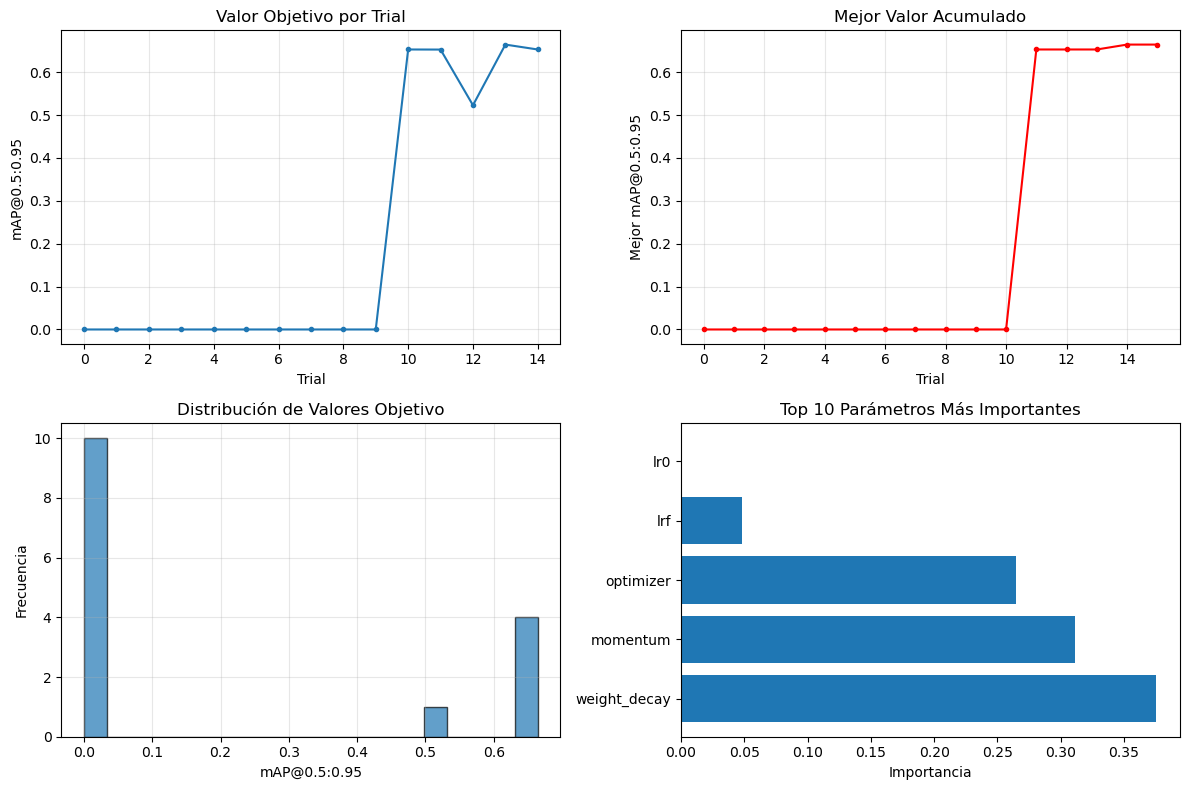

In [8]:
%matplotlib inline
optuna_utils.optuna_optimization_history(study, output_path=image_optuna_path)

In [9]:
with open(f"optuna/optuna_studies/{selected_model}_best_params.json", "r") as f:
    best_params = json.load(f)

print("Mejores hiperparámetros:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Mejores hiperparámetros:
  lr0: 0.0012123634441485443
  lrf: 0.006686145527494946
  momentum: 0.9498431644709179
  weight_decay: 0.0009155458747461034
  optimizer: Adam


### **K-Fold Cross Validation**

Se concatena train y val para tener un dataset mayor para k-fold 350 imagenes en 5 folds.

In [10]:
metrics_df = kfold_utils.train(model, best_params, model_output_kfold)


Entrenando fold_1 (1/5)
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_1\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0012123634441485443, lrf=0.006686145527494946, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo11l.pt, momentum=0.9498431644709179, mosaic=0, multi_scale=False, name=fold_12, nbs=64, nms=False, opset=None, optim

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_1\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 7.11.7 MB/s, size: 93.3 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_1\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\final_model_yolov11l_kfold\fold_12\labels.jpg... 
optimizer: Adam(lr=0.0012123634441485443, momentum=0.9498431644709179) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0009155458747461034), 173 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov11l_kfold\fold_12
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.49G      1.007     0.7985     0.8635         67        704: 100%|██████████| 70/70 [00:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        870      0.786      0.851      0.889      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.68G      1.014     0.7817     0.8782         19        704: 100%|██████████| 70/70 [00:47<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all         70        870      0.794      0.849       0.89      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.68G      1.059      0.846     0.8794         14        704: 100%|██████████| 70/70 [00:57<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all         70        870      0.795      0.835      0.888      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.68G      1.078     0.7852      0.882         56        704: 100%|██████████| 70/70 [01:21<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.16it/s]

                   all         70        870      0.786      0.846      0.884      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.68G      1.091     0.8074     0.8674         46        704: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]

                   all         70        870      0.806      0.832       0.89      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60       3.7G       1.09     0.8173     0.8748         44        704: 100%|██████████| 70/70 [01:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all         70        870      0.831      0.832      0.899      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.71G      1.057     0.7946     0.8661         59        704: 100%|██████████| 70/70 [01:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]

                   all         70        870      0.825      0.843      0.897      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.68G      1.048     0.7642     0.8714         76        704: 100%|██████████| 70/70 [00:46<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all         70        870      0.813      0.843       0.89      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.69G      1.079     0.7553     0.8794         36        704: 100%|██████████| 70/70 [00:49<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]

                   all         70        870      0.801      0.862       0.89      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.68G      1.116     0.7634     0.8837         39        704: 100%|██████████| 70/70 [00:46<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]

                   all         70        870      0.821      0.871      0.904      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.71G      1.074     0.7442     0.8745         41        704: 100%|██████████| 70/70 [01:42<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]

                   all         70        870      0.809      0.808      0.885      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.68G      1.047     0.7799     0.8723         50        704: 100%|██████████| 70/70 [00:48<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

                   all         70        870      0.776      0.834      0.878      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.68G      1.042     0.7666     0.8691         60        704: 100%|██████████| 70/70 [01:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all         70        870      0.784       0.83      0.876      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60       3.7G      1.016     0.7375     0.8708         18        704: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]

                   all         70        870      0.822      0.844      0.903      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.68G     0.9722     0.7066     0.8576         97        704: 100%|██████████| 70/70 [01:24<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

                   all         70        870      0.832      0.849      0.904      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60       3.7G     0.9766      0.725      0.857         31        704: 100%|██████████| 70/70 [01:13<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]

                   all         70        870      0.809      0.859      0.896      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.69G     0.9501     0.7062     0.8545         13        704: 100%|██████████| 70/70 [00:55<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

                   all         70        870       0.79      0.834       0.89      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.71G     0.9583     0.6996     0.8452         47        704: 100%|██████████| 70/70 [01:07<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        870      0.829      0.837      0.902      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.69G     0.9654     0.7292     0.8619         49        704: 100%|██████████| 70/70 [01:43<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all         70        870      0.824      0.874      0.914      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.55G     0.9685     0.7011      0.859         61        704: 100%|██████████| 70/70 [00:53<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]

                   all         70        870        0.8      0.841      0.895      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.69G     0.9484     0.6826     0.8594         41        704: 100%|██████████| 70/70 [01:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        870      0.822      0.852      0.903      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60       3.7G     0.9859     0.6929     0.8569         35        704: 100%|██████████| 70/70 [01:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all         70        870      0.822      0.862      0.911      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.68G     0.9412     0.6861      0.852         34        704: 100%|██████████| 70/70 [00:38<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all         70        870      0.805      0.861      0.903      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.69G     0.9376     0.7001     0.8565         91        704: 100%|██████████| 70/70 [00:55<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]

                   all         70        870      0.801      0.863      0.895      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.69G     0.9769      0.694     0.8585         60        704: 100%|██████████| 70/70 [01:11<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]

                   all         70        870      0.839      0.848      0.908       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60       3.7G     0.9801     0.6949     0.8704         17        704: 100%|██████████| 70/70 [00:48<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]

                   all         70        870      0.815      0.862      0.908       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.72G     0.9912     0.7287     0.8639         61        704: 100%|██████████| 70/70 [00:57<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all         70        870      0.823      0.861      0.906      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.68G     0.9777     0.6916     0.8468         32        704: 100%|██████████| 70/70 [01:07<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all         70        870      0.818      0.877      0.909      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.71G     0.9576     0.6908     0.8632         18        704: 100%|██████████| 70/70 [01:40<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all         70        870      0.831      0.873      0.916      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.69G     0.9608     0.6791     0.8473         63        704: 100%|██████████| 70/70 [01:19<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]

                   all         70        870      0.843      0.866      0.916       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60       3.7G     0.9259     0.6896     0.8405         23        704: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

                   all         70        870      0.815      0.854      0.899      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.67G     0.9179     0.6892     0.8526         68        704: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all         70        870       0.84      0.853      0.913      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.68G     0.9253     0.6663     0.8441         84        704: 100%|██████████| 70/70 [00:55<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all         70        870      0.838      0.871      0.918      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60       3.7G     0.9248     0.6712     0.8418         42        704: 100%|██████████| 70/70 [00:52<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        870      0.826      0.881      0.913      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.69G     0.9312     0.6827     0.8486         25        704: 100%|██████████| 70/70 [01:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all         70        870      0.814      0.871      0.903       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.68G     0.8972     0.6679     0.8542         52        704: 100%|██████████| 70/70 [00:55<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all         70        870      0.836       0.87      0.917      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.68G     0.9254     0.6775     0.8594         14        704: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

                   all         70        870      0.824      0.855      0.908      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.69G     0.9247     0.6535     0.8385         47        704: 100%|██████████| 70/70 [00:54<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

                   all         70        870      0.799      0.846      0.895      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.68G     0.9521     0.6761     0.8521         80        704: 100%|██████████| 70/70 [01:06<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all         70        870      0.808      0.841      0.898      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60       3.7G      0.881     0.6505     0.8417         42        704: 100%|██████████| 70/70 [01:25<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]

                   all         70        870      0.786      0.853      0.891       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.68G     0.8498     0.6503     0.8391         72        704: 100%|██████████| 70/70 [01:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all         70        870       0.81      0.846      0.897      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60       3.7G     0.8861     0.6534     0.8455         65        704: 100%|██████████| 70/70 [01:12<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

                   all         70        870      0.827       0.86      0.911      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.71G     0.9188      0.674     0.8461         64        704: 100%|██████████| 70/70 [01:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]

                   all         70        870      0.807      0.866      0.903      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.68G     0.8773     0.6417      0.841         34        704: 100%|██████████| 70/70 [00:45<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]

                   all         70        870      0.782      0.856      0.885      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.68G     0.8515     0.6417     0.8406         71        704: 100%|██████████| 70/70 [01:15<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        870      0.809      0.859      0.899      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.68G      0.853     0.6294     0.8422         49        704: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

                   all         70        870      0.849      0.851      0.913        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.68G     0.8646     0.6137     0.8515         78        704: 100%|██████████| 70/70 [00:43<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]

                   all         70        870      0.846      0.848      0.912      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.68G     0.8532     0.6106     0.8385         29        704: 100%|██████████| 70/70 [01:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]

                   all         70        870      0.833      0.854      0.911      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.71G     0.8637     0.6142     0.8533         45        704: 100%|██████████| 70/70 [01:08<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

                   all         70        870      0.837      0.853      0.913      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.69G     0.8574      0.619     0.8378         19        704: 100%|██████████| 70/70 [00:46<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

                   all         70        870      0.828      0.871      0.915      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.69G      0.877     0.6194     0.8424         60        704: 100%|██████████| 70/70 [01:13<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all         70        870       0.83      0.866      0.911        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60       3.7G     0.8512     0.5943     0.8432         66        704: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.50it/s]

                   all         70        870      0.803      0.862      0.894       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.67G     0.8532     0.6106     0.8364         31        704: 100%|██████████| 70/70 [01:02<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all         70        870       0.76      0.845      0.867       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.69G     0.8595     0.6263      0.837         87        704: 100%|██████████| 70/70 [01:24<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]

                   all         70        870      0.808      0.836      0.885       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.68G     0.8484     0.6046     0.8358         17        704: 100%|██████████| 70/70 [01:13<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

                   all         70        870      0.798      0.854       0.89      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.69G     0.8655     0.5986     0.8437         61        704: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all         70        870      0.819      0.864      0.905      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.68G      0.847     0.6102     0.8452         29        704: 100%|██████████| 70/70 [00:49<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.48it/s]

                   all         70        870       0.82      0.862      0.903      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.69G     0.8268     0.6216     0.8329         18        704: 100%|██████████| 70/70 [00:51<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.07it/s]

                   all         70        870      0.813      0.865      0.906      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.68G     0.8082     0.5856     0.8245         62        704: 100%|██████████| 70/70 [00:54<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.08it/s]

                   all         70        870      0.805       0.87      0.907      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.71G     0.7893     0.5715     0.8355          8        704: 100%|██████████| 70/70 [00:55<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]

                   all         70        870      0.808      0.872      0.908        0.7



60 epochs completed in 1.162 hours.
Optimizer stripped from runs\detect\final_model_yolov11l_kfold\fold_12\weights\last.pt, 51.2MB
Optimizer stripped from runs\detect\final_model_yolov11l_kfold\fold_12\weights\best.pt, 51.2MB

Validating runs\detect\final_model_yolov11l_kfold\fold_12\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.15it/s]


                   all         70        870      0.813      0.867      0.906      0.704
Speed: 0.8ms preprocess, 33.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\final_model_yolov11l_kfold\fold_12
Error leyendo métricas del fold 1: [Errno 2] No such file or directory: 'runs/detect/final_model_yolov11l_kfold/fold_1/results.csv'

Entrenando fold_2 (2/5)
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_2\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_2\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 628.51it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_2\train\labels.cache


val: Fast image access  (ping: 0.10.1 ms, read: 5.01.7 MB/s, size: 86.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_2\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 327.00it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_2\val\labels.cache


Plotting labels to runs\detect\final_model_yolov11l_kfold\fold_2\labels.jpg... 
optimizer: Adam(lr=0.0012123634441485443, momentum=0.9498431644709179) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0009155458747461034), 173 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov11l_kfold\fold_2
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.98G     0.9543     0.7063     0.8445         87        704: 100%|██████████| 70/70 [01:19<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

                   all         70       1019      0.851       0.88      0.921      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.62G     0.9563     0.6824     0.8458         26        704: 100%|██████████| 70/70 [01:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]

                   all         70       1019      0.863      0.743      0.813      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.71G     0.9732     0.7079     0.8565         75        704: 100%|██████████| 70/70 [00:46<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all         70       1019      0.861      0.854      0.911      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.69G      1.034      0.744     0.8659         93        704: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]

                   all         70       1019      0.806      0.846      0.882      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60       3.7G      1.003     0.7637     0.8448         31        704: 100%|██████████| 70/70 [00:32<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]

                   all         70       1019      0.721      0.831      0.741      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.68G     0.9424     0.7164     0.8479         57        704: 100%|██████████| 70/70 [00:37<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all         70       1019      0.847      0.845      0.889      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.69G     0.9547     0.7127      0.855         39        704: 100%|██████████| 70/70 [00:33<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]

                   all         70       1019      0.834      0.852      0.893      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60       3.7G     0.9251     0.7035     0.8473         37        704: 100%|██████████| 70/70 [00:37<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

                   all         70       1019      0.852      0.872      0.908      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.69G      1.003     0.6984     0.8519         34        704: 100%|██████████| 70/70 [00:44<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all         70       1019      0.854      0.848      0.904      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60       3.7G     0.9363     0.7038     0.8568         31        704: 100%|██████████| 70/70 [00:44<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

                   all         70       1019      0.832      0.836      0.894      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.71G     0.9243     0.6925     0.8434         64        704: 100%|██████████| 70/70 [01:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

                   all         70       1019      0.827       0.85      0.898      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.68G     0.9862     0.7301     0.8592         46        704: 100%|██████████| 70/70 [00:34<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all         70       1019       0.85      0.866       0.91      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.68G     0.9595     0.7128     0.8393         32        704: 100%|██████████| 70/70 [00:34<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]

                   all         70       1019      0.794      0.834       0.87      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.69G     0.9425     0.7176     0.8478         50        704: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70       1019      0.814      0.824      0.869      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.72G     0.9314     0.7036       0.85         38        704: 100%|██████████| 70/70 [00:44<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.14it/s]

                   all         70       1019      0.806      0.799      0.853      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.69G     0.9122     0.6828      0.854         43        704: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all         70       1019      0.877      0.865      0.916      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60       3.7G     0.9412     0.6965     0.8458         36        704: 100%|██████████| 70/70 [00:47<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]

                   all         70       1019      0.851      0.882      0.918      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60       3.7G      1.012     0.7032     0.8585         40        704: 100%|██████████| 70/70 [01:04<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70       1019      0.854      0.882      0.918      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.69G     0.9736     0.7049      0.848         16        704: 100%|██████████| 70/70 [00:36<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.09it/s]

                   all         70       1019      0.858      0.877      0.918      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.69G     0.9356     0.7104     0.8439         53        704: 100%|██████████| 70/70 [00:48<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]

                   all         70       1019      0.864      0.864      0.917       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.68G      0.912     0.6841     0.8396         41        704: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.13it/s]

                   all         70       1019      0.865      0.852      0.915      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.69G     0.9053      0.675     0.8462         25        704: 100%|██████████| 70/70 [00:53<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all         70       1019      0.853      0.868      0.918      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.69G     0.8956     0.6698     0.8505         73        704: 100%|██████████| 70/70 [00:58<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

                   all         70       1019       0.85      0.881      0.918      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.71G     0.8994     0.6574     0.8461         54        704: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.12it/s]

                   all         70       1019      0.864      0.864      0.914      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.69G     0.9342     0.6649     0.8561         34        704: 100%|██████████| 70/70 [00:53<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

                   all         70       1019      0.865      0.866      0.914      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.62G     0.9252     0.6781     0.8493         12        704: 100%|██████████| 70/70 [00:47<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70       1019       0.86      0.865      0.904      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60       3.7G     0.9008     0.6825     0.8452         71        704: 100%|██████████| 70/70 [00:36<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]

                   all         70       1019      0.856      0.841      0.885      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.68G      0.915     0.6688      0.843         21        704: 100%|██████████| 70/70 [00:52<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]

                   all         70       1019      0.862      0.871      0.911      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.71G     0.8458       0.63      0.839         44        704: 100%|██████████| 70/70 [00:58<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]

                   all         70       1019      0.874      0.861      0.915       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.73G     0.9222     0.6487     0.8399         61        704: 100%|██████████| 70/70 [00:36<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

                   all         70       1019      0.857      0.879      0.916      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.69G     0.9042     0.6734     0.8423         53        704: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70       1019      0.859      0.869      0.915      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.71G     0.8969     0.6532     0.8421         27        704: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.45it/s]

                   all         70       1019      0.839      0.884      0.911      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.69G     0.8952     0.6513     0.8416         56        704: 100%|██████████| 70/70 [00:58<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  3.00it/s]

                   all         70       1019        0.8      0.862      0.877      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.69G     0.8769     0.6554     0.8409         24        704: 100%|██████████| 70/70 [00:49<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]

                   all         70       1019      0.838      0.865      0.901      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.71G     0.9047     0.6742      0.844         32        704: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

                   all         70       1019      0.813       0.88        0.9      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.68G     0.9008     0.6528     0.8383         98        704: 100%|██████████| 70/70 [00:51<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70       1019      0.863      0.858       0.91      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60       3.7G     0.8994     0.6501     0.8411        106        704: 100%|██████████| 70/70 [00:38<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all         70       1019      0.881      0.857      0.919      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60       3.7G     0.8788     0.6403     0.8385         67        704: 100%|██████████| 70/70 [00:50<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all         70       1019      0.868      0.876      0.924      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.68G     0.8873     0.6549     0.8347         35        704: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.00it/s]

                   all         70       1019      0.875      0.868      0.922      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60       3.7G     0.8781     0.6394     0.8369         39        704: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all         70       1019      0.857      0.855      0.909      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.72G     0.8218     0.6216     0.8304         66        704: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]

                   all         70       1019      0.846      0.848      0.897      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60       3.7G     0.8323     0.6194     0.8319         23        704: 100%|██████████| 70/70 [00:42<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]

                   all         70       1019      0.882       0.85      0.918      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.68G     0.8427     0.6094     0.8234         63        704: 100%|██████████| 70/70 [01:01<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all         70       1019      0.888      0.854       0.92      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.68G     0.8298     0.6079     0.8302         87        704: 100%|██████████| 70/70 [01:19<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all         70       1019      0.886      0.846      0.917      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.69G      0.854     0.6078     0.8333         40        704: 100%|██████████| 70/70 [00:37<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]

                   all         70       1019      0.883      0.854      0.922      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.69G     0.8441     0.6012      0.833         29        704: 100%|██████████| 70/70 [00:52<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]

                   all         70       1019      0.878      0.865      0.921      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60       3.7G      0.826     0.6009     0.8394         63        704: 100%|██████████| 70/70 [00:52<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all         70       1019      0.884      0.863      0.922      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.69G     0.8404     0.6082      0.831         37        704: 100%|██████████| 70/70 [00:34<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]

                   all         70       1019      0.884      0.872      0.925      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.71G     0.8173     0.6124      0.838         20        704: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]

                   all         70       1019      0.871      0.879      0.926      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.71G      0.823     0.6038     0.8343         11        704: 100%|██████████| 70/70 [00:43<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]

                   all         70       1019      0.879      0.874      0.925      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60       3.7G      0.815     0.6019     0.8261         24        704: 100%|██████████| 70/70 [00:46<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all         70       1019      0.877      0.864      0.923      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.71G      0.816     0.6033     0.8329         39        704: 100%|██████████| 70/70 [01:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70       1019      0.879      0.845      0.914      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60       3.7G     0.8134     0.5817     0.8273         28        704: 100%|██████████| 70/70 [00:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all         70       1019      0.891      0.863      0.925      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.71G     0.8214     0.6033     0.8347         65        704: 100%|██████████| 70/70 [00:38<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]

                   all         70       1019      0.876      0.864      0.923      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.68G     0.8135     0.5808     0.8306         43        704: 100%|██████████| 70/70 [00:39<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]

                   all         70       1019      0.869      0.863      0.921      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.68G     0.8292     0.5895     0.8323         42        704: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]

                   all         70       1019      0.851      0.873      0.919      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.69G       0.78     0.5754      0.828         66        704: 100%|██████████| 70/70 [00:33<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]

                   all         70       1019      0.866      0.845      0.912      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.68G     0.8043     0.5858     0.8265         27        704: 100%|██████████| 70/70 [00:34<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

                   all         70       1019       0.87      0.854      0.916      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.69G     0.8152     0.5938     0.8254         76        704: 100%|██████████| 70/70 [00:32<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]

                   all         70       1019       0.87      0.857      0.914      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.71G     0.8156     0.5696     0.8374         17        704: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]

                   all         70       1019      0.879       0.85      0.919      0.712



60 epochs completed in 0.868 hours.
Optimizer stripped from runs\detect\final_model_yolov11l_kfold\fold_2\weights\last.pt, 51.2MB
Optimizer stripped from runs\detect\final_model_yolov11l_kfold\fold_2\weights\best.pt, 51.2MB

Validating runs\detect\final_model_yolov11l_kfold\fold_2\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.12it/s]


                   all         70       1019      0.877      0.862      0.923      0.717
Speed: 0.5ms preprocess, 33.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\final_model_yolov11l_kfold\fold_2

Entrenando fold_3 (3/5)
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_3\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001212363444

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_3\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 537.10it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_3\train\labels.cache


val: Fast image access  (ping: 0.20.2 ms, read: 5.31.6 MB/s, size: 95.1 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_3\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 357.14it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_3\val\labels.cache


Plotting labels to runs\detect\final_model_yolov11l_kfold\fold_3\labels.jpg... 
optimizer: Adam(lr=0.0012123634441485443, momentum=0.9498431644709179) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0009155458747461034), 173 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov11l_kfold\fold_3
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.96G     0.9015     0.6763     0.8616         60        704: 100%|██████████| 70/70 [01:51<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]

                   all         70        986      0.811      0.858      0.894       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.71G     0.8675     0.6616      0.841         38        704: 100%|██████████| 70/70 [00:45<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all         70        986      0.782      0.796      0.831      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60       3.7G     0.9332     0.6864     0.8515         35        704: 100%|██████████| 70/70 [00:37<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]

                   all         70        986      0.743      0.806      0.812      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.71G      0.912     0.6988     0.8438         99        704: 100%|██████████| 70/70 [00:38<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all         70        986      0.806      0.827      0.879      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.69G     0.9365     0.6857     0.8431         51        704: 100%|██████████| 70/70 [00:35<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

                   all         70        986      0.534      0.891      0.543      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60       3.7G     0.9137     0.6831     0.8406         19        704: 100%|██████████| 70/70 [00:37<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]

                   all         70        986     0.0544      0.738     0.0497     0.0346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.71G     0.9415     0.6996     0.8485         64        704: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.80it/s]

                   all         70        986      0.714       0.66      0.765      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.69G     0.9433     0.6975     0.8492         71        704: 100%|██████████| 70/70 [00:38<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

                   all         70        986      0.865      0.604      0.704      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.68G     0.9303     0.7012     0.8513         33        704: 100%|██████████| 70/70 [00:36<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]

                   all         70        986      0.806      0.774       0.83      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.71G     0.9387     0.6949     0.8558         94        704: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]

                   all         70        986      0.814      0.827      0.881      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.68G     0.9294     0.7029     0.8472         50        704: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

                   all         70        986      0.786      0.775      0.819      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.72G     0.9231     0.6659     0.8421         46        704: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all         70        986      0.811      0.801      0.867      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.69G     0.9152     0.6748     0.8397         19        704: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.00it/s]

                   all         70        986      0.824      0.807      0.885      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60       3.7G     0.9682     0.6787     0.8565         83        704: 100%|██████████| 70/70 [00:31<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]

                   all         70        986      0.815      0.808      0.864      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60       3.7G     0.8872     0.6372     0.8406         93        704: 100%|██████████| 70/70 [00:32<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all         70        986      0.814      0.803      0.866      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60       3.7G     0.8942     0.6444     0.8399         13        704: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]

                   all         70        986      0.804      0.805      0.869      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.69G     0.9291     0.6682     0.8373         50        704: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]

                   all         70        986      0.807       0.81      0.876       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.71G     0.9706     0.6728     0.8432         22        704: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

                   all         70        986      0.832      0.812      0.889      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.68G     0.8679     0.6559     0.8325         51        704: 100%|██████████| 70/70 [00:36<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]

                   all         70        986      0.804      0.824      0.883       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.73G     0.8616     0.6408     0.8411         32        704: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]

                   all         70        986      0.804      0.819      0.881      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.68G     0.8936     0.6436      0.844         12        704: 100%|██████████| 70/70 [00:37<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

                   all         70        986      0.809      0.831      0.883      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.71G     0.8646     0.6366      0.841         30        704: 100%|██████████| 70/70 [00:34<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all         70        986      0.801      0.842      0.879      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.69G     0.8979     0.6469     0.8453         15        704: 100%|██████████| 70/70 [00:34<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]

                   all         70        986      0.814      0.831      0.884      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60       3.7G      0.869     0.6387     0.8379         62        704: 100%|██████████| 70/70 [00:34<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]

                   all         70        986      0.819      0.856      0.899      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.68G     0.8758     0.6283      0.839         29        704: 100%|██████████| 70/70 [00:45<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all         70        986      0.811      0.848      0.888      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.71G     0.8991     0.6588      0.862          7        704: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]

                   all         70        986      0.803      0.839      0.882      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.71G     0.8441      0.652     0.8318         74        704: 100%|██████████| 70/70 [00:44<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

                   all         70        986      0.819      0.816      0.872      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.69G     0.8566     0.6127      0.824         22        704: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]

                   all         70        986      0.814      0.845      0.889      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.69G      0.831     0.6198     0.8376         35        704: 100%|██████████| 70/70 [00:38<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all         70        986      0.795      0.861      0.888      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.69G     0.8603     0.6302     0.8338        104        704: 100%|██████████| 70/70 [00:37<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]

                   all         70        986      0.811      0.838      0.887      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.69G     0.8432      0.614     0.8346         91        704: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all         70        986      0.803      0.861      0.887      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.69G     0.8714     0.6425     0.8431         26        704: 100%|██████████| 70/70 [00:36<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]

                   all         70        986      0.803      0.867      0.885      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.68G     0.8051     0.6109     0.8294         39        704: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]

                   all         70        986       0.81      0.837      0.884      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.71G     0.8405      0.635      0.833         10        704: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all         70        986      0.796      0.851       0.88      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.71G     0.8286     0.6101     0.8389         98        704: 100%|██████████| 70/70 [00:35<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        986      0.819       0.84      0.887      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.68G     0.8236     0.6009     0.8317         25        704: 100%|██████████| 70/70 [00:32<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]

                   all         70        986      0.817      0.813      0.886      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.71G     0.8675     0.6484     0.8375         79        704: 100%|██████████| 70/70 [00:45<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.17it/s]

                   all         70        986      0.834      0.823      0.888      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.71G     0.8477     0.6308     0.8299         62        704: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all         70        986      0.827      0.818      0.878      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.71G     0.8457     0.6105     0.8308         64        704: 100%|██████████| 70/70 [00:32<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]

                   all         70        986      0.834      0.829       0.89      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.69G     0.8144     0.6048     0.8231         46        704: 100%|██████████| 70/70 [00:33<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]

                   all         70        986      0.824      0.774      0.863      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.68G     0.8007     0.5925     0.8309         46        704: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]

                   all         70        986      0.838      0.828      0.893      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.68G     0.8144     0.5916     0.8305         56        704: 100%|██████████| 70/70 [00:34<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

                   all         70        986      0.856      0.802      0.885      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.71G     0.8105     0.5991     0.8275         34        704: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

                   all         70        986      0.818      0.842      0.882      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.69G      0.796     0.5893     0.8245        100        704: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]

                   all         70        986      0.811      0.838      0.884      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.72G     0.8078     0.6087     0.8291         62        704: 100%|██████████| 70/70 [00:37<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all         70        986       0.82      0.843      0.891       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       3.7G      0.804      0.581     0.8365         53        704: 100%|██████████| 70/70 [00:44<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        986      0.813      0.846      0.894      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.69G     0.7898     0.5832     0.8269         71        704: 100%|██████████| 70/70 [00:49<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]

                   all         70        986      0.829      0.823      0.888       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.71G     0.8047     0.5827     0.8268         28        704: 100%|██████████| 70/70 [00:49<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all         70        986      0.819      0.834      0.884      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60       3.7G     0.7808     0.5764     0.8244         52        704: 100%|██████████| 70/70 [00:49<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all         70        986      0.811      0.841      0.891       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.71G     0.7877     0.5762     0.8211         72        704: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all         70        986       0.82      0.832      0.893      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60       3.7G     0.7936     0.5796       0.83         40        704: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

                   all         70        986      0.844      0.815      0.895      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60       3.7G     0.8102     0.5788     0.8327         52        704: 100%|██████████| 70/70 [00:51<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]

                   all         70        986      0.829      0.832      0.889      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.71G     0.8085     0.5805     0.8324         49        704: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all         70        986      0.813      0.849      0.891      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.69G      0.784     0.5655     0.8198         16        704: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all         70        986      0.817      0.849      0.892      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60       3.7G      0.802     0.5659     0.8259         29        704: 100%|██████████| 70/70 [00:36<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all         70        986      0.833      0.823      0.892      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.69G     0.7771     0.5515     0.8231         52        704: 100%|██████████| 70/70 [00:36<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]

                   all         70        986      0.839      0.826      0.895      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60       3.7G     0.7799     0.5693     0.8303         13        704: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all         70        986      0.825       0.84      0.896      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.69G     0.7977     0.5838      0.836         63        704: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]

                   all         70        986      0.847      0.825      0.895      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.69G     0.7806     0.5485     0.8213         37        704: 100%|██████████| 70/70 [00:32<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]

                   all         70        986      0.854      0.816      0.896      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60       3.7G     0.7842     0.5666     0.8282         56        704: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]

                   all         70        986      0.852      0.817      0.896      0.695



60 epochs completed in 0.767 hours.
Optimizer stripped from runs\detect\final_model_yolov11l_kfold\fold_3\weights\last.pt, 51.2MB
Optimizer stripped from runs\detect\final_model_yolov11l_kfold\fold_3\weights\best.pt, 51.2MB

Validating runs\detect\final_model_yolov11l_kfold\fold_3\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


                   all         70        986      0.847      0.826      0.896      0.699
Speed: 0.6ms preprocess, 33.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\final_model_yolov11l_kfold\fold_3

Entrenando fold_4 (4/5)
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_4\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001212363444

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_4\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 548.60it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_4\train\labels.cache


val: Fast image access  (ping: 0.10.1 ms, read: 6.40.9 MB/s, size: 104.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_4\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 353.31it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_4\val\labels.cache


Plotting labels to runs\detect\final_model_yolov11l_kfold\fold_4\labels.jpg... 
optimizer: Adam(lr=0.0012123634441485443, momentum=0.9498431644709179) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0009155458747461034), 173 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov11l_kfold\fold_4
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.95G     0.9239     0.6517     0.8534         40        704: 100%|██████████| 70/70 [01:07<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]

                   all         70        992      0.783      0.848      0.889      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60       3.7G     0.8695     0.6561     0.8432         15        704: 100%|██████████| 70/70 [01:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

                   all         70        992      0.793      0.805       0.87      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.69G     0.9334     0.6795     0.8497         52        704: 100%|██████████| 70/70 [01:22<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all         70        992      0.771      0.714      0.763      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.71G     0.8808      0.638     0.8395         40        704: 100%|██████████| 70/70 [00:58<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]

                   all         70        992      0.831      0.741      0.768      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.69G     0.9654     0.6952     0.8474         56        704: 100%|██████████| 70/70 [00:42<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all         70        992      0.744      0.589      0.651      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60       3.7G     0.9059     0.6706     0.8451         39        704: 100%|██████████| 70/70 [01:43<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]

                   all         70        992      0.749      0.796      0.821      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60       3.7G     0.8929     0.6894     0.8403         90        704: 100%|██████████| 70/70 [01:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

                   all         70        992      0.776      0.799      0.837      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.61G     0.9356     0.6687     0.8454         65        704: 100%|██████████| 70/70 [01:24<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]

                   all         70        992      0.819      0.817      0.867      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.68G     0.9017     0.6782     0.8391         48        704: 100%|██████████| 70/70 [00:56<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

                   all         70        992      0.783      0.808      0.829      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.69G      0.893     0.6724     0.8455         17        704: 100%|██████████| 70/70 [00:39<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]

                   all         70        992      0.799      0.762      0.797      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.69G     0.8592     0.6948     0.8443         37        704: 100%|██████████| 70/70 [01:57<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        992       0.79       0.81      0.864      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.68G     0.8948     0.6676     0.8435         45        704: 100%|██████████| 70/70 [01:02<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.81it/s]

                   all         70        992      0.786       0.85      0.875      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.69G     0.8803     0.6642      0.839         80        704: 100%|██████████| 70/70 [00:42<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        992      0.813      0.841      0.896      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.71G     0.8839     0.6445     0.8397         56        704: 100%|██████████| 70/70 [00:43<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        992      0.797      0.838      0.891      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.68G     0.8814     0.6625     0.8411        138        704: 100%|██████████| 70/70 [01:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

                   all         70        992      0.781      0.821      0.877      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.71G      0.851     0.6265     0.8343          7        704: 100%|██████████| 70/70 [00:34<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.14it/s]

                   all         70        992      0.814      0.829      0.892      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.69G     0.8811     0.6468     0.8316         57        704: 100%|██████████| 70/70 [00:36<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

                   all         70        992      0.829      0.827      0.896      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60       3.7G     0.9266     0.6416     0.8542         14        704: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

                   all         70        992      0.785      0.868      0.887      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.71G      0.879     0.6476     0.8465         12        704: 100%|██████████| 70/70 [00:39<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all         70        992      0.811      0.825      0.892      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60       3.7G     0.8717     0.6334     0.8322          5        704: 100%|██████████| 70/70 [00:44<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]

                   all         70        992      0.797      0.839      0.889      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.69G     0.8774     0.6312     0.8399         43        704: 100%|██████████| 70/70 [01:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all         70        992      0.786      0.876        0.9      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.71G     0.8311     0.6127      0.833         12        704: 100%|██████████| 70/70 [00:38<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]

                   all         70        992      0.799      0.883      0.903      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.68G     0.9077     0.6403     0.8504          9        704: 100%|██████████| 70/70 [00:49<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]

                   all         70        992      0.762        0.8      0.839      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.71G      0.873     0.6342     0.8383         57        704: 100%|██████████| 70/70 [01:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

                   all         70        992      0.803      0.837      0.878      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.69G     0.8987     0.6416     0.8402         46        704: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

                   all         70        992      0.826      0.833      0.896      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60       3.7G     0.9116     0.6329     0.8444         20        704: 100%|██████████| 70/70 [01:13<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all         70        992      0.812      0.842        0.9      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.68G     0.8734     0.6204     0.8385         47        704: 100%|██████████| 70/70 [00:52<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]

                   all         70        992      0.793      0.848      0.887      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.71G     0.8665     0.6164     0.8367         36        704: 100%|██████████| 70/70 [00:44<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]

                   all         70        992      0.795       0.87      0.905      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60       3.7G     0.8273     0.6255     0.8398         17        704: 100%|██████████| 70/70 [00:53<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all         70        992      0.835      0.829      0.905       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.71G     0.8438       0.61     0.8399         70        704: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]

                   all         70        992      0.825       0.85      0.899       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60       3.7G     0.8597     0.6127     0.8324         43        704: 100%|██████████| 70/70 [00:38<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

                   all         70        992      0.817      0.854      0.895      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.69G     0.8258     0.5994      0.831         47        704: 100%|██████████| 70/70 [01:20<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all         70        992      0.832      0.832      0.904       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60       3.7G      0.869     0.5993     0.8314         31        704: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]

                   all         70        992      0.838      0.836      0.904      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60       3.7G     0.8408     0.6111     0.8351         51        704: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.20it/s]

                   all         70        992       0.83      0.842      0.907      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.73G      0.892     0.6042     0.8412         31        704: 100%|██████████| 70/70 [00:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]

                   all         70        992      0.836      0.826      0.897      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.69G     0.8526     0.6054     0.8413         18        704: 100%|██████████| 70/70 [00:59<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]

                   all         70        992      0.802       0.85      0.892      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.72G     0.8873     0.6166     0.8461         37        704: 100%|██████████| 70/70 [00:42<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]

                   all         70        992      0.798      0.857      0.891      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.71G     0.8569     0.6126     0.8279         68        704: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        992      0.841      0.819      0.892      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.68G     0.8624      0.605      0.835         16        704: 100%|██████████| 70/70 [00:37<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all         70        992      0.817      0.833       0.89      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.69G     0.8239     0.5941     0.8265         48        704: 100%|██████████| 70/70 [01:35<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70        992      0.855      0.817      0.908      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.69G     0.8252     0.5955     0.8388        120        704: 100%|██████████| 70/70 [01:25<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all         70        992      0.819      0.838      0.897      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.72G     0.8034     0.6019     0.8476         58        704: 100%|██████████| 70/70 [00:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

                   all         70        992       0.82      0.824      0.886      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60       3.7G     0.8187     0.6059     0.8283         54        704: 100%|██████████| 70/70 [00:44<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        992      0.817      0.844      0.893      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.68G     0.8058     0.5769     0.8276         51        704: 100%|██████████| 70/70 [00:56<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]

                   all         70        992      0.827      0.846        0.9      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.69G     0.7759     0.5627     0.8287         57        704: 100%|██████████| 70/70 [01:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]

                   all         70        992      0.793      0.871        0.9      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       3.7G     0.8198     0.5747      0.835         19        704: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

                   all         70        992      0.799      0.848      0.902      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60       3.7G     0.7979     0.5741     0.8245         79        704: 100%|██████████| 70/70 [00:39<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

                   all         70        992      0.814      0.852      0.902      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60       3.7G     0.8221     0.5746      0.829         21        704: 100%|██████████| 70/70 [00:44<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

                   all         70        992      0.809      0.855        0.9      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.72G     0.8142     0.5801     0.8382         32        704: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]

                   all         70        992      0.812      0.847      0.898      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.71G     0.7931     0.5721     0.8276         31        704: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]

                   all         70        992      0.828      0.833      0.886      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.71G     0.7952      0.559     0.8342         83        704: 100%|██████████| 70/70 [00:57<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all         70        992      0.811      0.846      0.877      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.71G     0.8144     0.5853     0.8357         43        704: 100%|██████████| 70/70 [00:38<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]

                   all         70        992      0.801      0.848      0.866      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.71G     0.7926     0.5785     0.8297         15        704: 100%|██████████| 70/70 [01:02<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.16it/s]

                   all         70        992      0.781      0.857      0.871      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.71G     0.7956     0.5609     0.8247         22        704: 100%|██████████| 70/70 [01:20<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]

                   all         70        992       0.82      0.829      0.878      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60       3.7G     0.7731     0.5672     0.8294         60        704: 100%|██████████| 70/70 [00:42<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all         70        992      0.825      0.848       0.89      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60       3.7G     0.8128     0.5685     0.8321         43        704: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        992       0.83      0.854      0.898      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60       3.7G     0.7689     0.5582     0.8369         61        704: 100%|██████████| 70/70 [00:39<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all         70        992      0.821      0.855      0.893      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.69G     0.7952     0.5667     0.8328         25        704: 100%|██████████| 70/70 [00:43<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.25it/s]

                   all         70        992      0.814       0.86      0.893      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60       3.7G     0.7806      0.557     0.8241         55        704: 100%|██████████| 70/70 [01:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        992      0.814      0.863      0.895      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.71G     0.7673     0.5626     0.8264         40        704: 100%|██████████| 70/70 [00:50<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        992       0.82      0.863      0.897      0.652



60 epochs completed in 1.035 hours.
Optimizer stripped from runs\detect\final_model_yolov11l_kfold\fold_4\weights\last.pt, 51.2MB
Optimizer stripped from runs\detect\final_model_yolov11l_kfold\fold_4\weights\best.pt, 51.2MB

Validating runs\detect\final_model_yolov11l_kfold\fold_4\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]


                   all         70        992        0.8      0.847      0.901      0.717
Speed: 0.4ms preprocess, 34.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\final_model_yolov11l_kfold\fold_4

Entrenando fold_5 (5/5)
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_5\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001212363444

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_5\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 650.08it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_5\train\labels.cache


val: Fast image access  (ping: 0.20.1 ms, read: 5.71.2 MB/s, size: 107.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_5\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 331.34it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_5\val\labels.cache


Plotting labels to runs\detect\final_model_yolov11l_kfold\fold_5\labels.jpg... 
optimizer: Adam(lr=0.0012123634441485443, momentum=0.9498431644709179) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0009155458747461034), 173 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov11l_kfold\fold_5
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.96G     0.8883     0.6509     0.8394         68        704: 100%|██████████| 70/70 [01:16<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all         70        945      0.853      0.816       0.89      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.71G     0.9289     0.7033     0.8407         20        704: 100%|██████████| 70/70 [01:18<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.08it/s]

                   all         70        945      0.861      0.801      0.899      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.69G      0.919      0.671     0.8499         83        704: 100%|██████████| 70/70 [01:13<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        945      0.823      0.829      0.892      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.69G     0.9157     0.7046     0.8392         28        704: 100%|██████████| 70/70 [00:47<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]

                   all         70        945       0.82      0.815      0.887       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.71G      0.998     0.7493     0.8646         26        704: 100%|██████████| 70/70 [01:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all         70        945      0.837      0.811      0.891      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.71G     0.9047     0.7211     0.8556         25        704: 100%|██████████| 70/70 [00:44<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

                   all         70        945      0.818      0.838      0.886      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.72G     0.9196     0.7057      0.847         44        704: 100%|██████████| 70/70 [00:42<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all         70        945      0.811      0.849      0.895      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.68G     0.9354     0.7039     0.8557         32        704: 100%|██████████| 70/70 [00:49<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70        945      0.799      0.842      0.877      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.71G     0.9396     0.7074      0.849         18        704: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        945      0.791      0.815      0.844      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.69G     0.8561     0.6518     0.8357         39        704: 100%|██████████| 70/70 [01:08<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

                   all         70        945      0.829      0.815      0.881      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.69G     0.8628      0.659     0.8354         43        704: 100%|██████████| 70/70 [00:49<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]

                   all         70        945      0.846      0.798      0.884      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.69G     0.9187       0.68     0.8514         67        704: 100%|██████████| 70/70 [00:42<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]

                   all         70        945       0.84      0.798      0.885      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.69G     0.9021     0.6582     0.8368         62        704: 100%|██████████| 70/70 [01:24<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]

                   all         70        945      0.838       0.84      0.895      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.71G     0.8901     0.6437     0.8439         23        704: 100%|██████████| 70/70 [01:22<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        945      0.817      0.843       0.89      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60       3.7G     0.9329     0.6903      0.847         49        704: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]

                   all         70        945       0.79      0.847      0.882      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.68G     0.9426     0.7002     0.8435         63        704: 100%|██████████| 70/70 [00:36<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]

                   all         70        945      0.814      0.848      0.891      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60       3.7G     0.9813     0.6849     0.8475         53        704: 100%|██████████| 70/70 [00:48<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all         70        945      0.817       0.83      0.886      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.71G     0.9337     0.6568     0.8376         68        704: 100%|██████████| 70/70 [01:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all         70        945      0.839      0.816      0.888      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.69G     0.8896     0.6539     0.8352         65        704: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        945      0.844      0.814      0.885      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.69G     0.8364     0.6304     0.8317         99        704: 100%|██████████| 70/70 [00:38<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.14it/s]

                   all         70        945      0.824      0.816      0.884      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.71G     0.8652      0.637     0.8334         31        704: 100%|██████████| 70/70 [01:17<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all         70        945       0.84      0.821      0.889      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.68G     0.8496     0.6434     0.8331         62        704: 100%|██████████| 70/70 [00:43<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]

                   all         70        945      0.786      0.872      0.895      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60       3.7G     0.8625     0.6514     0.8482         66        704: 100%|██████████| 70/70 [00:42<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        945      0.822      0.826      0.894      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60       3.7G     0.8252     0.6163     0.8336         51        704: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]

                   all         70        945      0.823      0.839      0.898      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.69G     0.8486     0.6175     0.8343         57        704: 100%|██████████| 70/70 [00:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        945       0.83      0.849      0.902       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.71G     0.8702     0.6275     0.8361         77        704: 100%|██████████| 70/70 [01:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]

                   all         70        945      0.833       0.85        0.9       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.71G     0.8443     0.6344     0.8457         71        704: 100%|██████████| 70/70 [01:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.80it/s]

                   all         70        945      0.848      0.821      0.898      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.69G     0.8092     0.6081     0.8257         17        704: 100%|██████████| 70/70 [00:45<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]

                   all         70        945      0.886      0.801      0.908      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.71G     0.8116     0.6125     0.8328         34        704: 100%|██████████| 70/70 [00:57<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all         70        945      0.836       0.83        0.9      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60       3.7G     0.8419     0.6141     0.8295         94        704: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]

                   all         70        945      0.872      0.802      0.901       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.72G     0.8297     0.6171     0.8255         84        704: 100%|██████████| 70/70 [00:47<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]

                   all         70        945      0.828      0.839      0.901      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.71G     0.8605     0.6238     0.8437         23        704: 100%|██████████| 70/70 [00:58<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]

                   all         70        945      0.821      0.826      0.894      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.69G     0.8263     0.6097     0.8324         28        704: 100%|██████████| 70/70 [00:59<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all         70        945      0.823      0.828      0.893       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.71G     0.8511     0.6113     0.8367         19        704: 100%|██████████| 70/70 [00:45<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all         70        945      0.843      0.833      0.902      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.71G     0.8699     0.6155     0.8296         30        704: 100%|██████████| 70/70 [00:51<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]

                   all         70        945      0.826      0.825      0.886      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.71G     0.8389     0.6088     0.8313         36        704: 100%|██████████| 70/70 [00:44<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]

                   all         70        945      0.827      0.819      0.883      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60       3.7G     0.8396     0.6105     0.8257         44        704: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]

                   all         70        945       0.85      0.826      0.893      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.69G     0.8465     0.6228     0.8315         53        704: 100%|██████████| 70/70 [01:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.59it/s]

                   all         70        945      0.844       0.83      0.895      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60       3.7G     0.8159     0.6189     0.8343         82        704: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]

                   all         70        945      0.852      0.817      0.897      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.69G     0.8004     0.5802     0.8218         59        704: 100%|██████████| 70/70 [00:38<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

                   all         70        945      0.818      0.819      0.882      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.71G     0.7949     0.5788      0.823         69        704: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        945      0.814      0.838       0.89      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60       3.7G     0.7846     0.5768     0.8394         25        704: 100%|██████████| 70/70 [00:39<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]

                   all         70        945      0.816      0.851      0.893      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.69G      0.834     0.5911     0.8302         39        704: 100%|██████████| 70/70 [01:14<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        945      0.866      0.797      0.897      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.69G     0.7935     0.5867     0.8239         67        704: 100%|██████████| 70/70 [01:21<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]

                   all         70        945      0.839      0.817      0.894       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.72G     0.8158     0.5775     0.8202         28        704: 100%|██████████| 70/70 [01:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]

                   all         70        945      0.842      0.828        0.9      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       3.7G     0.8048     0.5876      0.834         43        704: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]

                   all         70        945      0.851      0.815        0.9      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.71G     0.7922     0.5659     0.8252         19        704: 100%|██████████| 70/70 [00:51<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.00it/s]

                   all         70        945      0.855      0.817      0.899      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.68G     0.7871      0.574     0.8286         30        704: 100%|██████████| 70/70 [00:58<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all         70        945      0.844       0.83      0.897      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.69G     0.7841     0.5821     0.8355         33        704: 100%|██████████| 70/70 [00:58<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

                   all         70        945      0.865      0.812      0.899      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.69G     0.7741     0.5661     0.8224         15        704: 100%|██████████| 70/70 [00:42<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

                   all         70        945       0.86      0.812      0.898      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60       3.7G     0.7905     0.5806     0.8311         35        704: 100%|██████████| 70/70 [01:11<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.13it/s]

                   all         70        945      0.848      0.826      0.896      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.71G     0.7679     0.5578     0.8321         50        704: 100%|██████████| 70/70 [00:55<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70        945      0.852      0.828      0.897       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60       3.7G     0.7613     0.5518     0.8266         10        704: 100%|██████████| 70/70 [00:57<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]

                   all         70        945      0.865      0.816      0.902      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.71G     0.7848     0.5588     0.8279         79        704: 100%|██████████| 70/70 [00:38<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]

                   all         70        945      0.867      0.805        0.9      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.69G     0.7769     0.5602     0.8329         34        704: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        945      0.863       0.81      0.899      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.69G     0.7913     0.5612     0.8299         73        704: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

                   all         70        945      0.852      0.818      0.898      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60       3.7G     0.7779     0.5639     0.8273         48        704: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]

                   all         70        945      0.852      0.807      0.894      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.69G      0.762     0.5544     0.8169         57        704: 100%|██████████| 70/70 [00:36<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]

                   all         70        945      0.859      0.805      0.898      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60       3.7G     0.7671     0.5523     0.8192         50        704: 100%|██████████| 70/70 [00:44<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]

                   all         70        945      0.865      0.803      0.898      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.71G     0.7575     0.5386     0.8224         38        704: 100%|██████████| 70/70 [00:50<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.16it/s]

                   all         70        945      0.867        0.8      0.898      0.683



60 epochs completed in 0.980 hours.
Optimizer stripped from runs\detect\final_model_yolov11l_kfold\fold_5\weights\last.pt, 51.2MB
Optimizer stripped from runs\detect\final_model_yolov11l_kfold\fold_5\weights\best.pt, 51.2MB

Validating runs\detect\final_model_yolov11l_kfold\fold_5\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]


                   all         70        945      0.787      0.872      0.895      0.704
Speed: 0.4ms preprocess, 34.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\final_model_yolov11l_kfold\fold_5


In [11]:
kfold_utils.save_results(metrics_df, model_output_kfold)


Resultados por fold:
   fold  mAP50-95    mAP50  precision   recall
0     2   0.71630  0.92301    0.87642  0.86359
1     3   0.69843  0.89535    0.84662  0.82454
2     4   0.71676  0.90158    0.79869  0.84786
3     5   0.70405  0.89517    0.78647  0.87196

Promedio de métricas:
fold         3.500000
mAP50-95     0.708885
mAP50        0.903778
precision    0.827050
recall       0.851988
dtype: float64

Directorios temporales eliminados.


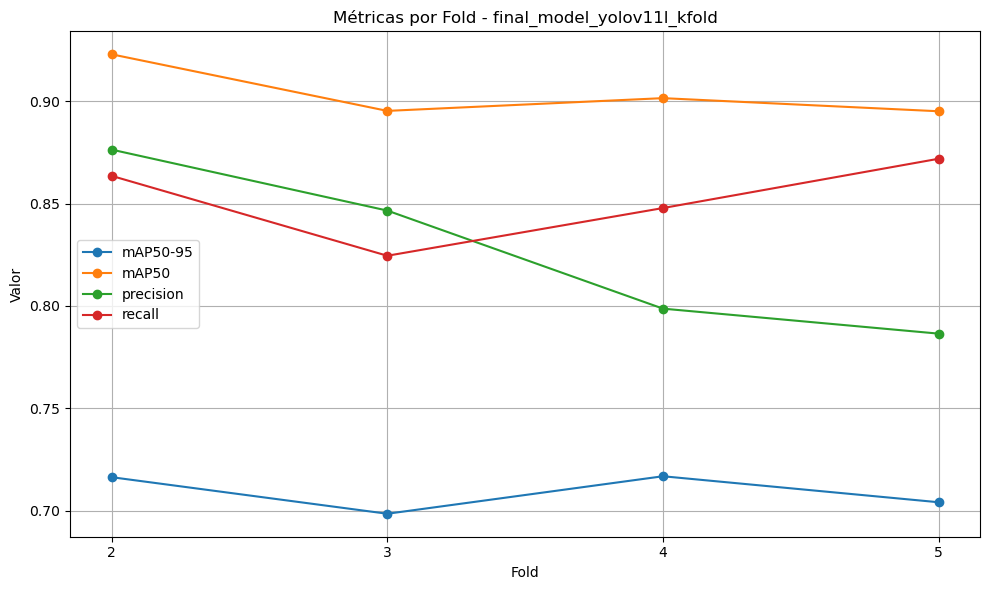

In [12]:
kfold_utils.plot_kfold_metrics(metrics_df, model_output_kfold)

### **Train**

In [13]:
model.train(
    data="cells.yaml",
    epochs=config.EPOCH_TRAIN,   
    imgsz=config.IMGSZ,          
    batch=config.BATCH,           
    name=model_output,
    save=True,         
    **best_params      
)

Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0012123634441485443, lrf=0.006686145527494946, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo11l.pt, momentum=0.9498431644709179, mosaic=0, multi_scale=False, name=final_model_yolov11l, nbs=64, nms=False, opset=None, optimize=False, optimizer=Ada

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 235.024.4 MB/s, size: 109.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\final_model_yolov11l\labels.jpg... 
optimizer: Adam(lr=0.0012123634441485443, momentum=0.9498431644709179) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0009155458747461034), 173 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov11l
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.96G      0.907     0.6717     0.8432         41        704: 100%|██████████| 70/70 [01:17<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]

                   all         70        889      0.753      0.803      0.845      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.71G     0.8755     0.6646     0.8419         25        704: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70        889      0.827      0.848       0.89      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.69G      0.884     0.6812     0.8386         44        704: 100%|██████████| 70/70 [01:21<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all         70        889      0.838      0.825      0.887      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.72G     0.8739     0.6479     0.8408         24        704: 100%|██████████| 70/70 [01:12<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.26it/s]

                   all         70        889      0.833      0.839      0.888      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.69G     0.9002     0.6809     0.8338         79        704: 100%|██████████| 70/70 [00:49<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]

                   all         70        889      0.807      0.837      0.873      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.71G     0.9068      0.681     0.8561         69        704: 100%|██████████| 70/70 [00:44<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

                   all         70        889      0.804      0.818      0.867      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60       3.7G     0.8877     0.6561     0.8408         40        704: 100%|██████████| 70/70 [00:37<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]

                   all         70        889       0.83       0.82      0.873      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.69G     0.8637     0.6479      0.841         40        704: 100%|██████████| 70/70 [00:38<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]

                   all         70        889      0.834      0.834      0.884      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.69G     0.8532      0.648     0.8407         11        704: 100%|██████████| 70/70 [00:47<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

                   all         70        889      0.817      0.856      0.884      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60       3.7G      0.841      0.642     0.8348         38        704: 100%|██████████| 70/70 [01:28<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all         70        889      0.813      0.863      0.882      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.69G     0.8796     0.6332     0.8439         22        704: 100%|██████████| 70/70 [00:45<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

                   all         70        889      0.818      0.837      0.872      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.73G     0.9197     0.6587     0.8399         19        704: 100%|██████████| 70/70 [01:20<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]

                   all         70        889      0.803      0.841      0.868      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60       3.7G     0.8995     0.6307     0.8371         33        704: 100%|██████████| 70/70 [00:44<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]

                   all         70        889      0.839       0.83      0.873       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.69G     0.8919     0.6283     0.8454         28        704: 100%|██████████| 70/70 [00:53<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]

                   all         70        889      0.835       0.84      0.883      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.71G     0.8331     0.6245     0.8334         60        704: 100%|██████████| 70/70 [00:53<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

                   all         70        889      0.838      0.846      0.886       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.71G     0.8712     0.6468     0.8416         62        704: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all         70        889      0.824      0.866      0.887      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.71G     0.9109     0.6562     0.8391         86        704: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all         70        889      0.814      0.832      0.871      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.71G     0.9167      0.654     0.8421         34        704: 100%|██████████| 70/70 [00:48<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]

                   all         70        889      0.829      0.839      0.883      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.68G      0.864     0.6397     0.8352        107        704: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all         70        889      0.799      0.831      0.864      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.71G     0.8542     0.6192     0.8295         17        704: 100%|██████████| 70/70 [01:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all         70        889       0.79      0.845      0.865      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.71G     0.8664     0.6107     0.8398         32        704: 100%|██████████| 70/70 [00:44<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

                   all         70        889      0.824      0.838      0.887      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.68G     0.8845     0.6299     0.8382         57        704: 100%|██████████| 70/70 [00:55<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]

                   all         70        889      0.802      0.845      0.875      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60       3.7G     0.8651     0.6362     0.8332         34        704: 100%|██████████| 70/70 [00:57<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all         70        889      0.801      0.835       0.87      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.71G     0.8647     0.6254     0.8293         56        704: 100%|██████████| 70/70 [00:48<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

                   all         70        889      0.833      0.832      0.886      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.71G     0.8553     0.6184     0.8377         37        704: 100%|██████████| 70/70 [00:58<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.28it/s]

                   all         70        889      0.817      0.823      0.879      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.72G     0.8238     0.6077     0.8287         45        704: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        889      0.855      0.814      0.886      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.71G     0.8455     0.6206     0.8338         87        704: 100%|██████████| 70/70 [00:57<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all         70        889      0.826      0.829      0.882      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.68G     0.8484     0.6135     0.8212         14        704: 100%|██████████| 70/70 [00:52<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70        889      0.824       0.84      0.881      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.69G     0.8264     0.6044     0.8328         38        704: 100%|██████████| 70/70 [01:14<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all         70        889       0.84      0.832       0.89      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.69G     0.8225     0.6135     0.8306         76        704: 100%|██████████| 70/70 [00:44<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]

                   all         70        889      0.826      0.853      0.889      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.71G     0.8366     0.6158     0.8365         86        704: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all         70        889      0.843      0.837      0.889       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.69G     0.8123     0.5943     0.8348         49        704: 100%|██████████| 70/70 [01:12<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]

                   all         70        889      0.828      0.843      0.892      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.69G     0.8105     0.6081     0.8263         81        704: 100%|██████████| 70/70 [01:15<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all         70        889      0.852       0.82      0.892      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60       3.7G     0.8476     0.6029     0.8432         35        704: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

                   all         70        889       0.85      0.825      0.893      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.68G     0.8636     0.6032     0.8286         78        704: 100%|██████████| 70/70 [01:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all         70        889      0.838      0.843      0.895      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.71G     0.8479     0.6091     0.8368         20        704: 100%|██████████| 70/70 [00:44<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]

                   all         70        889      0.839      0.846      0.896      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60       3.7G     0.8301     0.5925     0.8279         69        704: 100%|██████████| 70/70 [01:12<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]

                   all         70        889       0.85       0.85      0.897      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.72G     0.8187     0.5985     0.8232         97        704: 100%|██████████| 70/70 [00:54<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all         70        889      0.844      0.858      0.895       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.71G      0.856     0.6131     0.8454         76        704: 100%|██████████| 70/70 [00:42<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]

                   all         70        889      0.852      0.853      0.899      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60       3.7G     0.8149     0.5787     0.8278         62        704: 100%|██████████| 70/70 [01:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all         70        889      0.851      0.848      0.899      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60       3.7G     0.7761     0.5855     0.8339         39        704: 100%|██████████| 70/70 [00:52<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all         70        889       0.84      0.852      0.897      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.69G     0.8053      0.583      0.828         17        704: 100%|██████████| 70/70 [00:45<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

                   all         70        889       0.84       0.85      0.893       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.69G     0.8106     0.5806     0.8298         70        704: 100%|██████████| 70/70 [00:53<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]

                   all         70        889      0.822      0.852      0.891      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.71G     0.7872     0.5782     0.8296         15        704: 100%|██████████| 70/70 [01:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all         70        889      0.849      0.832      0.893      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60       3.7G     0.7937     0.5919      0.828         28        704: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.00it/s]

                   all         70        889      0.854      0.831      0.896      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.68G     0.7997     0.5712     0.8332         15        704: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.50it/s]

                   all         70        889      0.842      0.848      0.898      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.71G     0.7925     0.5723     0.8214         77        704: 100%|██████████| 70/70 [00:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        889      0.851      0.843      0.895      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.69G     0.8093     0.5718     0.8267        149        704: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]

                   all         70        889       0.83      0.857      0.893      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60       3.7G     0.7997     0.5676     0.8328          8        704: 100%|██████████| 70/70 [01:28<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70        889      0.821      0.858      0.891      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.72G     0.7983     0.5666     0.8261         14        704: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all         70        889      0.836      0.858      0.897      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60       3.7G     0.7708     0.5562     0.8257         38        704: 100%|██████████| 70/70 [00:42<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]

                   all         70        889      0.838      0.858      0.896      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60       3.7G     0.7626     0.5468     0.8282         22        704: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all         70        889       0.85      0.843      0.894      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.69G     0.7875     0.5667     0.8305         16        704: 100%|██████████| 70/70 [00:43<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]

                   all         70        889      0.841      0.849      0.893       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.69G     0.7726     0.5557     0.8218         47        704: 100%|██████████| 70/70 [01:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.35it/s]

                   all         70        889      0.835      0.856      0.894      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.69G     0.7855     0.5521      0.825         13        704: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]

                   all         70        889      0.828      0.863      0.895      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60       3.7G     0.7635     0.5505     0.8186         80        704: 100%|██████████| 70/70 [01:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

                   all         70        889      0.825      0.866      0.894        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.69G     0.7493     0.5402     0.8232         65        704: 100%|██████████| 70/70 [00:37<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

                   all         70        889      0.836      0.849      0.893      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.69G     0.8019     0.5733     0.8309         25        704: 100%|██████████| 70/70 [00:57<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all         70        889      0.845      0.846      0.895      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60       3.7G     0.7797     0.5552      0.819         54        704: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

                   all         70        889      0.855       0.84      0.896      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.69G     0.7677     0.5447     0.8312         25        704: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]

                   all         70        889      0.852      0.838      0.896      0.661



60 epochs completed in 1.040 hours.
Optimizer stripped from runs\detect\final_model_yolov11l\weights\last.pt, 51.2MB
Optimizer stripped from runs\detect\final_model_yolov11l\weights\best.pt, 51.2MB

Validating runs\detect\final_model_yolov11l\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


                   all         70        889      0.851      0.849      0.899      0.713
Speed: 0.4ms preprocess, 34.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs\detect\final_model_yolov11l


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001EFB6207A50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### **Train Plots**

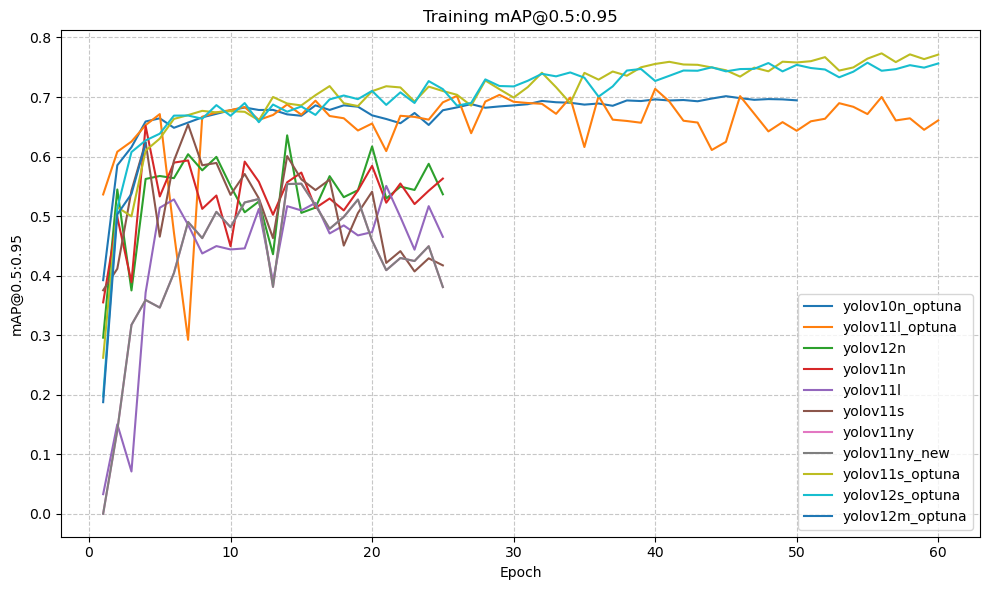

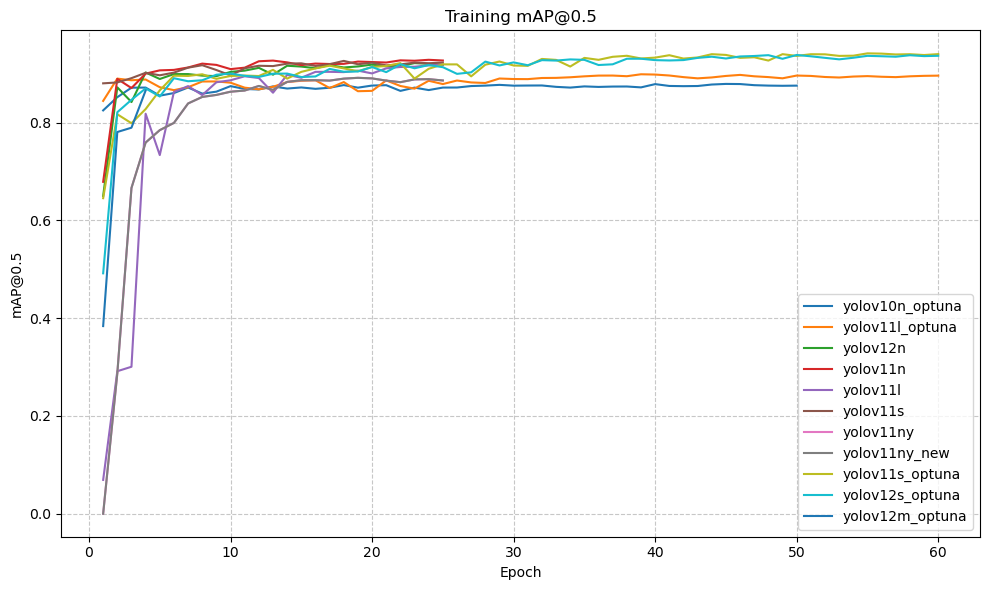

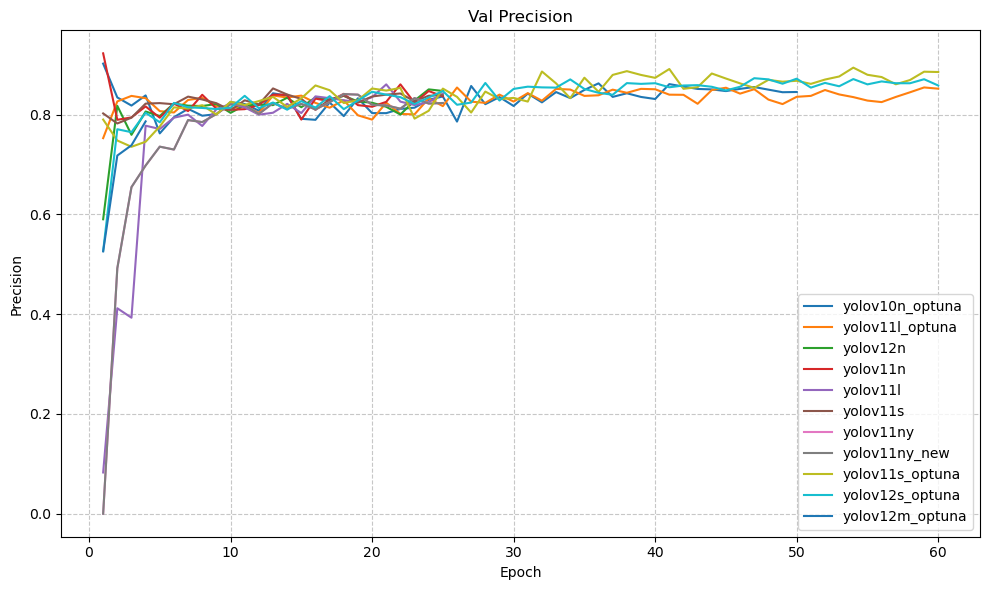

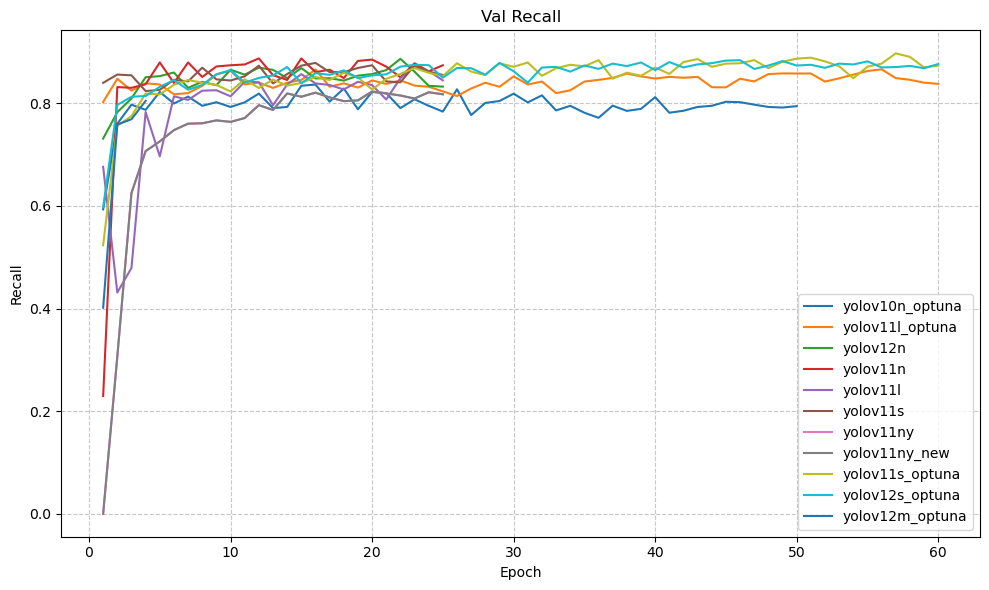

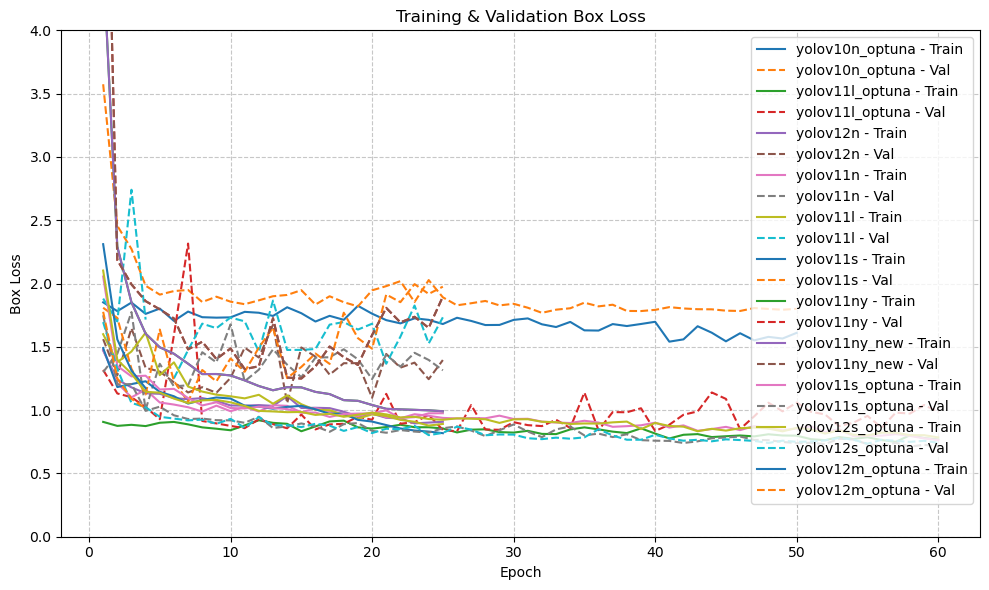

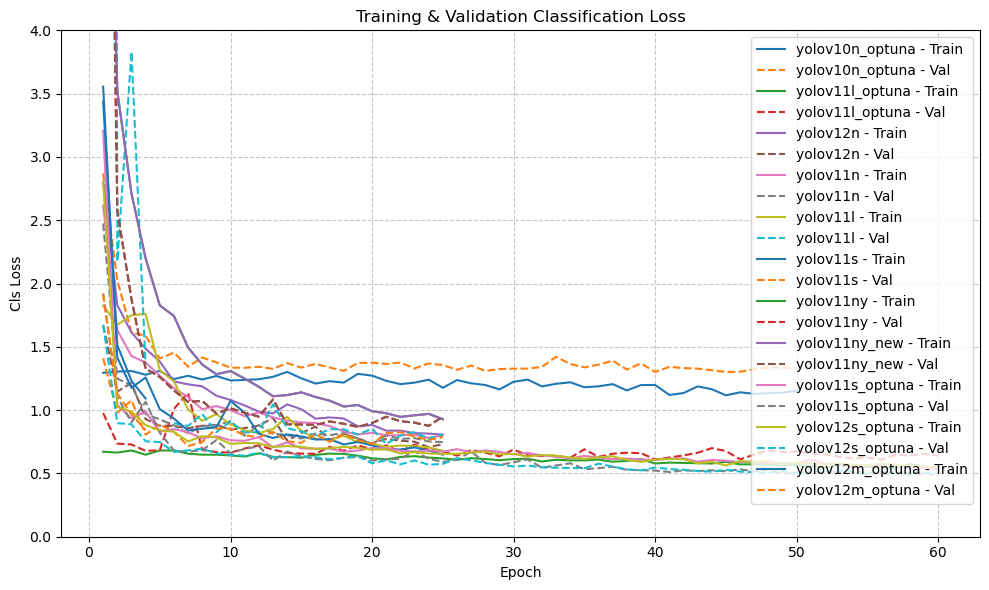

In [6]:
plots_dir = 'yolo_output/yolo_plots'
dfs = plot_utils.load_experiment_results(config.results_csv_paths)

plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50-95', 'metrics/mAP50-95(B)', 'Training mAP@0.5:0.95', 'mAP@0.5:0.95')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50', 'metrics/mAP50(B)', 'Training mAP@0.5', 'mAP@0.5')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'precision', 'metrics/precision(B)', 'Val Precision', 'Precision')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'recall', 'metrics/recall(B)', 'Val Recall', 'Recall')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'box_loss', ['train/box_loss', 'val/box_loss'], 
                               'Training & Validation Box Loss', 'Box Loss', True, (0, 4))
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'cls_loss', ['train/cls_loss', 'val/cls_loss'], 
                               'Training & Validation Classification Loss', 'Cls Loss', True, (0, 4))

## **Evaluaciones de empresa**

In [8]:
def process_images(directorio_entrada, directorio_referencia, directorio_salida, modelo_path):
    """
    Process all images in a directory with YOLO and compare with reference images.
    
    Args:
        directorio_entrada: Path to directory containing input images
        directorio_referencia: Path to directory containing reference images
        directorio_salida: Path to save output comparison images
        modelo_path: Path to YOLO model weights
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(directorio_salida):
        os.makedirs(directorio_salida)
        print(f"Directorio creado: {directorio_salida}")
    else:
        print(f"Usando directorio de salida: {directorio_salida}")
    
    modelo_personalizado = YOLO(modelo_path)
    
    archivos_entrada = [f for f in os.listdir(directorio_entrada) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not archivos_entrada:
        print(f"No se encontraron imágenes en {directorio_entrada}")
        return
    
    print(f"Procesando {len(archivos_entrada)} imágenes...")
    
    for nombre_archivo in archivos_entrada:
        print(f"Procesando: {nombre_archivo}")
        ruta_imagen = os.path.join(directorio_entrada, nombre_archivo)
        
        nombre_base = os.path.splitext(nombre_archivo)[0]
        nombre_referencia = f"{nombre_base}_.jpg"
        ruta_imagen_referencia = os.path.join(directorio_referencia, nombre_referencia)
        
        if not os.path.exists(ruta_imagen_referencia):
            print(f"Advertencia: No se encontró la imagen de referencia {nombre_referencia}")
            ruta_imagen_referencia = None
        
        resultados = modelo_personalizado(ruta_imagen)
        
        for r in resultados:
            num_detecciones = len(r.boxes)

            im_array = r.plot(labels=False, conf=True)

            font = cv2.FONT_HERSHEY_SIMPLEX
            texto_contador = f"{num_detecciones}"

            # Calculamos el tamaño del texto para posicionarlo correctamente
            textSize = cv2.getTextSize(texto_contador, font, 0.8, 2)[0]
            
            # Posicionamos en la esquina superior derecha con un margen de 20px
            text_x = im_array.shape[1] - textSize[0] - 20
            text_y = 30  # 30px desde la parte superior
            
            # Dibujamos el texto
            cv2.putText(im_array, texto_contador, (text_x, text_y), font, 0.8, (255, 255, 255), 2)
            
            if ruta_imagen_referencia:
                img_referencia = cv2.imread(ruta_imagen_referencia)
                
                h1, w1 = im_array.shape[:2]
                h2, w2 = img_referencia.shape[:2]
                
                if h1 != h2:
                    if h1 > h2:
                        new_w2 = int(w2 * (h1 / h2))
                        img_referencia = cv2.resize(img_referencia, (new_w2, h1))
                    else:
                        new_w1 = int(w1 * (h2 / h1))
                        im_array = cv2.resize(im_array, (new_w1, h2))
                
                img_combinada = cv2.hconcat([im_array, img_referencia])
                
                cv2.line(img_combinada, (im_array.shape[1], 0), (im_array.shape[1], img_combinada.shape[0]), (90, 70, 255), 2)
                
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(img_combinada, "YOLO", (10, 30), font, 1, (0, 255, 0), 2)
                cv2.putText(img_combinada, "IR", (im_array.shape[1] + 10, 30), font, 1, (0, 255, 0), 2)
                
                ruta_salida = os.path.join(directorio_salida, f"comparacion_{nombre_archivo}")
                cv2.imwrite(ruta_salida, img_combinada)
            else:
                ruta_salida = os.path.join(directorio_salida, f"yolo_{nombre_archivo}")
                cv2.imwrite(ruta_salida, im_array)
            
    print(f"Procesamiento completado. Resultados guardados en {directorio_salida}")

Añadir la evaluación sobre el conjunto de test

In [10]:
modelo_path = '.\\runs\\detect\\final_model_optunav12s\\weights\\best.pt'

# DEFAULT dataset
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\INPUT DEFAULT",
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\OUTPUT_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\YOLO_NEW",
    modelo_path
)

# TEST 2
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\INPUT TEST_2",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\OUTPUT_TEST 2_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\YOLO_NEW",
    modelo_path
)

# TEST 3
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\INPUT_TEST 3",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\OUTPUT_TEST 3_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\YOLO_NEW",
    modelo_path
)

# TEST 4
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\INPUT_TEST 4",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\OUTPUT_TEST 4_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\YOLO_NEW",
    modelo_path
)

Usando directorio de salida: ..\03.Datasets\Evaluacion_Empresa\DEFAULT\YOLO_NEW
Procesando 94 imágenes...
Procesando: 110.jpg
Advertencia: No se encontró la imagen de referencia 110_.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFAULT\INPUT DEFAULT\110.jpg: 576x704 1 cell, 32.8ms
Speed: 3.5ms preprocess, 32.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 704)
Procesando: 116.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFAULT\INPUT DEFAULT\116.jpg: 576x704 36 cells, 29.3ms
Speed: 4.3ms preprocess, 29.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 704)
Procesando: 124.jpg
Advertencia: No se encontró la imagen de referencia 124_.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFAUL

añadir kfold y una función general que importe con un import para generar una carpeta con los resultados de la evaluación de cada imagen del test/defalut/eval_empresa 

Probar a entrenar Yolo con capas de atención y mucho más personalizados algunos modelos.

 hacer RFHF con yolo?

## **Conclusión**

## **Comentarios reunión semanal**

Para el power point usar el mes gratis de copilot, así lo redacto mejor y más rápido la presentación

"no es posible distinguir entre leucocitos y células germinales inmaduras con un alto grado de certeza (2)" https://pmc.ncbi.nlm.nih.gov/articles/PMC8915675/

Quiero probar este modelo: https://github.com/Peterande/D-FINE?tab=readme-ov-file